In [55]:
import os
import pandas as pd
import numpy as np
from typing import Dict, List
import importlib
from pathlib import Path
import matplotlib.pyplot as plt
import MeCab
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import plotly.io as pio
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import seaborn as sns
import gc

In [56]:
#INFO: import local libraries
import python.data_manager as dm
import python.Mecab_processing as mp
import python.util as util

In [57]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
FIG_PATH = BASE_PATH / "fig"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")


BASE_PATH: /home/masa1357/Dockerdata/gitfile/15-Encoders
DATA_PATH: /home/masa1357/Dockerdata/gitfile/15-Encoders/data
MODEL_PATH: /home/masa1357/Dockerdata/gitfile/15-Encoders/model


In [58]:
importlib.reload(util)
# ? logger読み込み
name = "15-Ensemble"
logger = util.set_logger()
# ? seed値固定
seed = 42
util.set_seed(seed)

2024-07-26 05:25:30,047 : python.util : INFO : 34 : Test_message


In [59]:
# ? データ読み込み
# import python.data_manager as dm

importlib.reload(dm)
# argsでloggerの名前を送る
args: Dict[str, object] = {
    "logger": logger,
    "DATA_PATH": DATA_PATH,
    "key": "userid",
    "text": "answer_content",
    "label": "grade",
    "mode" : "all",
    "split_rate": [0.8, 0.2, 0],
    "seed": seed,
}

with util.timer("load data"):
    dp = dm.DataProcessing(args)
    df= dp()

2024-07-26 05:25:30,062 : python.util.python.data_manager : INFO : 16 : setup Child logger : python.data_manager
2024-07-26 05:25:30,063 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection *.csv data...
2024-07-26 05:25:30,065 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPath('/home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection/Course_C-2021-2_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection/Course_C-2022-1_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/15-Encoders/data/Reflection/Course_C-2021-1_Reflection.csv')]
2024-07-26 05:25:30,160 : python.util.python.data_manager : INFO : 74 : Total rows: 28275
2024-07-26 05:25:30,161 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/15-Encoders/data/Grade *.csv data...
2024-07-26 05:25:30,163 : python.util.python.data_manager : INFO : 67 : Found files: [Pos

[load data] start
[load data] done in 0.78 s


In [60]:
df

userid grade                                               text  \
0        C-2021-1_U1     F       情報伝達には声モルス信号など様々な形があり人類の進化と共により高度に精度が高められてきた   
1       C-2021-1_U10     B  高校時代で習った情報だけでは現代の進化についていけない\r\n情報はどんな形であっても〇と●...   
2      C-2021-1_U100     C                               情報の発展の仕方\r\n授業の参加の仕方   
3      C-2021-1_U101     B  電子教科書BookRoll学習支援ダッシュボドの使い方の説明とデジタル情報がどのように伝わっ...   
4      C-2021-1_U102     B                情報科学という学問とその中の情報に関する点についてのイントロダクション   
...              ...   ...                                                ...   
28037   C-2022-1_U85     B  授業の最初のほうは初めて聞く言葉ばかりで戸惑うことも多かったが情報科学という分野に慣れていく...   
28038   C-2022-1_U86     C                                     今までありがとうございました   
28041   C-2022-1_U89     B  今日は60分間テストの後アンケトに答えて授業が終わるという日でしたので新たに知識を発見すると...   
28042    C-2022-1_U9     C                   〆切が50分までなら50分に提出することはできるのかできないのか   
28047   C-2022-1_U94     C                          全力を尽くしたつもりです前期ありがとうございました   

      course_number question_number  label  
0                01               1      4  
1                01               1      1  
2                01               1      2  
3                01               1      1  
4                01               1      1  
...             ...             ...    ...  
28037            15               5      1  
28038            15               5      2  
28041            15               5      1  
28042            15               5      2  
28047            15               5      2  

[20291 rows x 6 columns]

### 簡単な可視化
- 成績ごとの単語数分布
- 質問ごとの単語数分布
- 講義回ごとの単語数分布
  

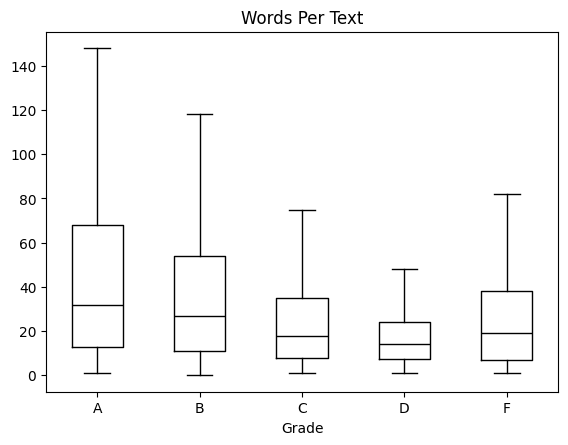

In [61]:
#INFO: 成績ごとの単語数の分布を確認

mecab = MeCab.Tagger()
def count_words(text):
    node = mecab.parseToNode(text)
    word_count = 0
    while node:
        if node.surface:
            word_count += 1
        node = node.next
    return word_count

df['Words Per Text'] = df['text'].apply(count_words)
df.boxplot(column="Words Per Text", by="grade",grid=False, showfliers=False,color='black')

plt.suptitle("")
plt.xlabel("Grade")

# plt.savefig(FIG_PATH/"words_per_text_Grade.svg")
plt.show()

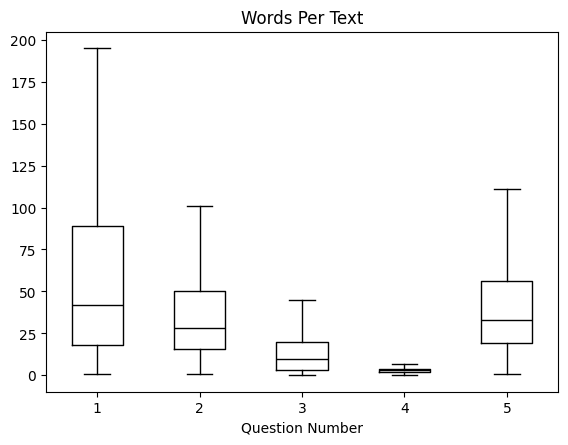

In [62]:
# INFO: 質問ごとの単語数の分布を確認
df.boxplot(column="Words Per Text", by="question_number",grid=False, showfliers=False,color='black')
plt.suptitle("")
plt.xlabel("Question Number")
# plt.savefig(FIG_PATH / "words_per_text_Question.svg")
plt.show()

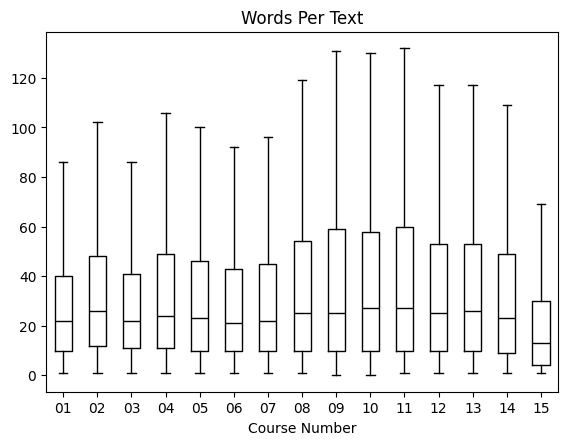

In [63]:
# INFO: 講義回数ごとの単語数の分布を確認
df.boxplot(column="Words Per Text", by="course_number",grid=False, showfliers=False,color='black')
plt.suptitle("")
plt.xlabel("Course Number")
# plt.savefig(FIG_PATH / "words_per_text_Cource.svg")
plt.show()

### 生徒ごとに、講義回数毎の回答文の変化を確認
1. 各生徒の回答を時系列でグループ化
2. 生徒の回答文を何らかの形でプロット
3. 時系列上にシークバーを設定、移動量を確認する

#### 1. 各生徒の回答を時系列でグループ化

In [64]:
# 質問番号でフィルタ
filter = "1"
Qfilter_df = dm.encode(df, logger=logger, filter=filter)
# Qfilter_df.head()

/home/masa1357/Dockerdata/gitfile/15-Encoders/src/python/data_manager.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "new_column"] = df.apply(create_column_name, axis=1)


In [65]:
Qfilter_df.head(3)

new_column         userid  label  \
0             C-2021-1_U1      4   
1            C-2021-1_U10      1   
2           C-2021-1_U100      2   

new_column                                               01-1  \
0                情報伝達には声モルス信号など様々な形があり人類の進化と共により高度に精度が高められてきた   
1           高校時代で習った情報だけでは現代の進化についていけない\r\n情報はどんな形であっても〇と●...   
2                                        情報の発展の仕方\r\n授業の参加の仕方   

new_column                                               02-1  \
0           情報源符号化とは情報を黒と白の○で表すことで複合とは符号化によって得られたものを元に戻す作業...   
1           どのように情報を短く表現するか\r\n符号をを一意に素早く戻すためにはどのような符号にすればよいか   
2                        情報源符号化によって情報が伝えられるときより軽く瞬時に伝わるような仕組み   

new_column                                               03-1  \
0           生起確率pの事象の生起を知ったことによる曖昧さの減少量は情報量と一致し生起確率pが高いほど情...   
1           情報の量を表すためにはどのようにすればよいか\r\n2つの現象が起こった場合相互の情報量はど...   
2                                                エントロピ情報量について   

new_column                                               04-1  \
0           通信の際に符号の誤りを検出・訂正する仕組みについて学んだ符号の誤りは符号語同士がs+1以上離...   
1                     誤りの自動検出と自動訂正が可能なハミング距離\r\n符号化効率とブロック誤り率   
2                       通信路符号化ビット反転によってノイズが生じる仕組み自動訂正自動検出について   

new_column                                               05-1  \
0           コンピュタサイエンスは計算機科学であるともされ全ての科学技術分野の基盤となりうるものであるコ...   
1           基礎科学としてのコンピュタサイエンス\r\nコンピュタサイエンスにおける計算と問題とは何か\...   
2                                        計算とアルゴリズムについて効率のよい計算   

new_column                                               06-1  \
0           計算ステップ数とはアルゴリズムが終了するまでに行われる演算の数である最大公約数の問題では剰余...   
1                                   色々なソトの種類とその計算時間量や比較回数\r\n   
2                                                 いろいろなソトについて   

new_column                                               07-1  \
0           マジソトとは入力数列を分割していき分割したものを整列して統合(マジ)するアルゴリズムであるヒ...   
1                             マジソトと2分探索法\r\n比較ベスのソトアルゴリズムのまとめ   
2                                               マジソト2分探索法について   

new_column                           08-1  \
0                                    [NA]   
1           デタとは何か\r\nデタの予測発見分類・グルピング\r\n   
2                                  デタについて   

new_column                                               09-1  \
0                                                        [NA]   
1           人工知能(AI)特化型AIとは何か\r\n身の回りの人工知能\r\n人工知能の機械学習\r\...   
2                                                 AIについての基礎情報   

new_column                                  10-1  \
0                                           [NA]   
1           非構造化デタの処理\r\nパタン認識とは何か\r\nパタン認識と機械学習   
2                                 非構造デタとはパタン認識とは   

new_column                                   11-1  \
0                                            [NA]   
1               デタ収集とバイアス\r\n個人情報とデタ\r\nオプンデタについて   
2           デタの収集にはどのような方法があるのか調査方法バイアスとは個人情報について   

new_column                                               12-1  \
0                                                        [NA]   
1           ベクトルによるデタ表現ベクトルとは何か\r\nベクトルとデタ分析の関係\r\n距離や類似度と...   
2                               ベクトルについていろいろな距離についてデタにおける類似とは   

new_column                               13-1  \
0                                        [NA]   
1           デタの可視化とは\r\n色々な可視化方法\r\n多次元デタの可視化   
2                                  デタの可視化について   

new_column                                         14-1             15-1  
0                                                  [NA]             [NA]  
1           相関デタの広がりと分散\r\n統計的検定とは何か\r\n画像処理と解析(フィルタ処理)  期末テスト\r\n授業アンケト  
2                     デタの間の関係性相関統計的検定について画像解析フィルタ処理について            期末テスト

#### 2. 生徒の回答データを可視化

In [66]:
#INFO:各成績で抽出
index = {0:"A", 1:"B", 2:"C", 3:"D", 4:"F"}
grade_df = {}

for i in range(5):
    grade_df[i] = Qfilter_df[Qfilter_df["label"] == i]
    print(f"grade_df_{index[i]}: {grade_df[i].shape}")

grade_df_A: (41, 17)
grade_df_B: (178, 17)
grade_df_C: (103, 17)
grade_df_D: (20, 17)
grade_df_F: (32, 17)


In [67]:
#INFO: それぞれの成績の各講義内で、[NA](特殊トークン)の数をカウント
count =[0, 0, 0, 0, 0]
for i in range(5):
    for j in range(1,16):
        column_name = f"{j:02d}-{filter}"
        count[i] += grade_df[i][grade_df[i][column_name] == "[NA]"].shape[0]
    print(f"count_{index[i]}: {count[i]}")

count_A: 15
count_B: 146
count_C: 231
count_D: 101
count_F: 368


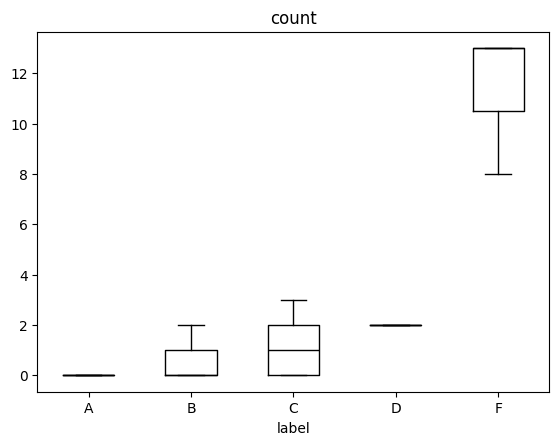

In [68]:
# INFO: 各行のNAの数をカウント、列に追加
NAcntdf = pd.DataFrame()
for i in range(5):
    temp_df = pd.DataFrame()
    temp_df["label"] = [i] * grade_df[i].shape[0]
    temp_df["grade"] = [index[i]] * grade_df[i].shape[0]
    temp_df["count"] = grade_df[i].apply(lambda x: x.tolist().count("[NA]"), axis=1)
    NAcntdf = pd.concat([NAcntdf, temp_df], ignore_index=True)

NAcntdf.boxplot(column="count", by="grade", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("label")
# plt.savefig(FIG_PATH / "NA_count.svg")
plt.show()

##### fastTextで各講義の分散表現を取得

In [69]:
importlib.reload(mp)
# argsでloggerの名前を送る
args: Dict[str, object] = {
    "logger": logger,
    "MODEL_PATH": MODEL_PATH,
    "seed": seed,
}


with util.timer("Load Model..."):
    gs = mp.GetSentenceVector(args, df[df["question_number"] == filter])

[Load Model...] start


100%|██████████| 4749/4749 [00:00<00:00, 9721.06it/s] 
2024-07-26 05:25:33,491 : python.util.python.Mecab_processing : INFO : 68 : loading word2vec model ...
2024-07-26 05:25:33,670 : python.util.python.Mecab_processing : INFO : 70 : model loaded.


[Load Model...] done in 0.67 s


In [70]:
# testname = "01-1"
# columns = ["userid", testname, "label"]
# test_X, test_Y = gs(corpus_df=df, plot_df=grade_df[0][columns], key=testname)

In [71]:
# # PCAのインスタンスを作成し、2次元に削減する設定
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(test_X)

# # PCAの結果をDataFrameに変換
# pca_df = pd.DataFrame(X_pca, columns=["Principal Component 1", "Principal Component 2"])
# pca_df["Category"] = test_Y["category_id"].values  # カテゴリーラベルを追加

In [72]:
# fig = px.scatter(
#     pca_df,
#     x="Principal Component 1",
#     y="Principal Component 2",
#     color=pca_df["Category"].astype(str),
#     labels={"color": "Category"},
#     title="PCA Visualization of Document Vectors",
#     width=800,
#     height=800,
# )
# fig.update_traces(
#     marker=dict(size=5, opacity=0.8, line=dict(width=0.5, color="DarkSlateGrey"))
# )
# fig.show()

In [73]:
Qfilter_df.columns

Index(['userid', 'label', '01-1', '02-1', '03-1', '04-1', '05-1', '06-1',
       '07-1', '08-1', '09-1', '10-1', '11-1', '12-1', '13-1', '14-1', '15-1'],
      dtype='object', name='new_column')

In [74]:
Qfilter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userid  374 non-null    object
 1   label   374 non-null    int64 
 2   01-1    374 non-null    object
 3   02-1    374 non-null    object
 4   03-1    374 non-null    object
 5   04-1    374 non-null    object
 6   05-1    374 non-null    object
 7   06-1    374 non-null    object
 8   07-1    374 non-null    object
 9   08-1    374 non-null    object
 10  09-1    374 non-null    object
 11  10-1    374 non-null    object
 12  11-1    374 non-null    object
 13  12-1    374 non-null    object
 14  13-1    374 non-null    object
 15  14-1    374 non-null    object
 16  15-1    374 non-null    object
dtypes: int64(1), object(16)
memory usage: 49.8+ KB


In [75]:
data_X = {}
data_Y = {}
texts = {}

for j in range(1,16):
    column_name = f"{j:02d}-{filter}"
    columns = ["userid", column_name, "label"]
    with util.timer(f"GetSentenceVector:{column_name}"):
        data_X[j], data_Y[j], texts[j] = gs(plot_df=Qfilter_df[columns], key=column_name)


[GetSentenceVector:01-1] start


374it [00:00, 4977.82it/s]


[GetSentenceVector:01-1] done in 0.09 s
[GetSentenceVector:02-1] start


374it [00:00, 4808.36it/s]


[GetSentenceVector:02-1] done in 0.09 s
[GetSentenceVector:03-1] start


374it [00:00, 5794.84it/s]


[GetSentenceVector:03-1] done in 0.08 s
[GetSentenceVector:04-1] start


374it [00:00, 4909.75it/s]


[GetSentenceVector:04-1] done in 0.10 s
[GetSentenceVector:05-1] start


374it [00:00, 5158.57it/s]


[GetSentenceVector:05-1] done in 0.09 s
[GetSentenceVector:06-1] start


374it [00:00, 4125.92it/s]


[GetSentenceVector:06-1] done in 0.11 s
[GetSentenceVector:07-1] start


374it [00:00, 4377.17it/s]


[GetSentenceVector:07-1] done in 0.10 s
[GetSentenceVector:08-1] start


374it [00:00, 4098.49it/s]


[GetSentenceVector:08-1] done in 0.11 s
[GetSentenceVector:09-1] start


374it [00:00, 3100.46it/s]


[GetSentenceVector:09-1] done in 0.14 s
[GetSentenceVector:10-1] start


374it [00:00, 3838.40it/s]


[GetSentenceVector:10-1] done in 0.11 s
[GetSentenceVector:11-1] start


374it [00:00, 3087.17it/s]


[GetSentenceVector:11-1] done in 0.14 s
[GetSentenceVector:12-1] start


374it [00:00, 4193.38it/s]


[GetSentenceVector:12-1] done in 0.11 s
[GetSentenceVector:13-1] start


374it [00:00, 3862.90it/s]


[GetSentenceVector:13-1] done in 0.11 s
[GetSentenceVector:14-1] start


374it [00:00, 3832.08it/s]


[GetSentenceVector:14-1] done in 0.11 s
[GetSentenceVector:15-1] start


374it [00:00, 24508.55it/s]

[GetSentenceVector:15-1] done in 0.03 s


In [76]:
data_X[1].head()

X1        X2        X3        X4        X5        X6        X7  \
0 -0.107732  0.157712 -0.003512 -0.119415 -0.206122  0.071285  0.066599   
1 -0.065380  0.071883  0.027485  0.009310 -0.051815  0.142453 -0.058239   
2 -0.100060  0.085419 -0.006374 -0.005583 -0.139123  0.062130 -0.080010   
3 -0.060522  0.095147 -0.023516  0.045938 -0.108916  0.034509 -0.037212   
4 -0.154873  0.109866 -0.049866  0.037662 -0.107469  0.065842 -0.041761   

         X8        X9       X10  ...      X191      X192      X193      X194  \
0  0.075405 -0.010701  0.077698  ...  0.009526  0.055880 -0.046172  0.102872   
1  0.119955  0.048686 -0.026047  ...  0.037710  0.048016 -0.042010  0.047079   
2  0.226250 -0.023167  0.020545  ...  0.046271 -0.088996  0.042958  0.180556   
3  0.123516 -0.088119 -0.032989  ... -0.015248  0.006370 -0.031334  0.131425   
4  0.130860  0.018807 -0.060163  ...  0.117773 -0.015050  0.062499  0.022863   

       X195      X196      X197      X198      X199      X200  
0 -0.006416 -0.037198 -0.013182  0.064599 -0.014231 -0.104789  
1 -0.011342 -0.051091  0.028656  0.093894  0.019968 -0.136878  
2  0.019899  0.046705  0.075384  0.139640  0.108191 -0.158022  
3  0.046752  0.061902  0.031747  0.011159  0.077298 -0.053238  
4 -0.068105 -0.012521  0.061980  0.004520  0.104526 -0.205179  

[5 rows x 200 columns]

In [77]:
pca_df = {}

# 一貫したPCAモデルの作成
pca = PCA(n_components=2)
all_data = np.vstack([data_X[i] for i in range(1, 16)])
pca.fit(StandardScaler().fit_transform(all_data))


for i in range(1, 16):
    column_name = f"{i:02d}-{filter}"
    with util.timer(f"PCA:{column_name}"):
        X_scaled = StandardScaler().fit_transform(data_X[i])
        X_pca = pca.transform(X_scaled)
        pca_df[i] = pd.DataFrame(X_pca, columns=["Principal Component 1", "Principal Component 2"])
        pca_df[i]["Category"] = data_Y[i]["category_id"].values
        pca_df[i]["text"] = texts[i]

# for i in range(1,16):
#     column_name = f"{i:02d}-{filter}"
#     with util.timer(f"PCA:{column_name}"):
#         # PCAのインスタンスを作成し、2次元に削減する設定
#         pca = PCA(n_components=2)
#         X_pca = pca.fit_transform(data_X[i])

#         # PCAの結果をDataFrameに変換
#         pca_df[i] = pd.DataFrame(X_pca, columns=["Principal Component 1", "Principal Component 2"])
#         pca_df[i]["Category"] = data_Y[i]["category_id"].values  # カテゴリーラベルを追加

[PCA:01-1] start
[PCA:01-1] done in 0.01 s
[PCA:02-1] start
[PCA:02-1] done in 0.02 s
[PCA:03-1] start
[PCA:03-1] done in 0.01 s
[PCA:04-1] start
[PCA:04-1] done in 0.01 s
[PCA:05-1] start
[PCA:05-1] done in 0.01 s
[PCA:06-1] start
[PCA:06-1] done in 0.01 s
[PCA:07-1] start
[PCA:07-1] done in 0.01 s
[PCA:08-1] start
[PCA:08-1] done in 0.01 s
[PCA:09-1] start
[PCA:09-1] done in 0.00 s
[PCA:10-1] start
[PCA:10-1] done in 0.00 s
[PCA:11-1] start
[PCA:11-1] done in 0.01 s
[PCA:12-1] start
[PCA:12-1] done in 0.00 s
[PCA:13-1] start
[PCA:13-1] done in 0.01 s
[PCA:14-1] start
[PCA:14-1] done in 0.01 s
[PCA:15-1] start
[PCA:15-1] done in 0.00 s


In [78]:
# from sklearn.manifold import TSNE

# # 一貫したt-SNEモデルの作成
# all_data = np.vstack([data_X[i] for i in range(1, 16)])
# all_data_scaled = StandardScaler().fit_transform(all_data)
# with util.timer(f"T-SNE base train"):
#     tsne = TSNE(n_components=2, random_state=42)
#     all_data_tsne = tsne.fit_transform(all_data_scaled)

# # 各ステップで同じt-SNEモデルを使用してデータを変換
# pca_df = {}
# start_idx = 0
# for i in range(1, 16):
#     column_name = f"{i:02d}-{filter}"
#     with util.timer(f"T-SNE:{column_name}"):
#         end_idx = start_idx + data_X[i].shape[0]
#         X_tsne = all_data_tsne[start_idx:end_idx]
#         pca_df[i] = pd.DataFrame(X_tsne, columns=["Component 1", "Component 2"])
#         pca_df[i]["Category"] = data_Y[i]["category_id"].values
#         start_idx = end_idx

In [79]:
#pca_dfをcategory_idでソート
for i in range(1,16):
    pca_df[i] = pca_df[i].sort_values("Category")

pca_df[1].head(10)

Principal Component 1  Principal Component 2  Category  \
128               0.348208               2.711089         0   
130              -1.496821              -1.139748         0   
124               0.585913               0.655526         0   
119              -1.383374              -0.833928         0   
109              -1.233930              -0.240898         0   
326              -1.733567              -1.357601         0   
327              -1.217049              -0.899360         0   
319              -3.691358              -1.586341         0   
328              -1.242545              -1.898972         0   
331               0.262138               2.216879         0   

                                                  text  
128  今日の授業はこれからの授業の説明や青色のMoodleの使い方の説明また情報電達の歴史・方法(...  
130  様々な情報を伝達する手段は会話から文字や道具の使用によってだんだんと変化した今ではパソコン等...  
124  電子教科書の使い方を教えてもらった\r\n情報がいかにして送られるかを抽象的に学びそれに付随...  
119  電子教科書の利用法と情報についての基礎知識\r\n現代の情報のやり取りは音や光などの情報を０...  
109  今回は初めて使用するタイプのMoodleの使い方や情報科学の授業でどのようなことを学んでいく...  
326  情報科学の学習について\r\n情報科学は理科の基礎科目である日本の情報科学は1970年代に情...  
327    情報通信機器では情報は０と１のように表される\r\n情報通信は多くの歴史を経て現在の形になった  
319              情報は0と1で表される\r\nデタ量\r\n情報源符号化通信路符号化暗号化  
328                                       情報は簡単にして送られる  
331                              授業オリエンテション\r\n情報とはなにか

In [80]:
#INFO: 可視化のため、pca_dfから30個のデータを抽出
#INFO: Categoryが0から4までのデータをそれぞれ6個ずつ抽出
# sample_df = pd.DataFrame()
# for i in range(1,16):
#     sample_df = pd.concat([sample_df, pca_df[i].sample(n=6, random_state=seed)], ignore_index=True)


In [81]:
def plot_pca_with_slider(pca_df):
    """
    PCAの結果をインタラクティブにプロットする関数
    :param pca_df: 各PCA結果のデータフレームを格納した辞書
    """
    fig = go.Figure()

    # 各フレームを追加
    frames = []
    for i in range(1, 16):
        plot_df = pca_df[i]
        unique_categories = plot_df["Category"].unique()
        data = []
        for category in unique_categories:
            df_category = plot_df[plot_df["Category"] == category]
            data.append(
                go.Scatter(
                    x=df_category["Principal Component 1"],
                    y=df_category["Principal Component 2"],
                    mode="markers",
                    marker=dict(color=category, colorscale="Viridis"),
                    name=f"{index[category]}",
                    legendgroup=f"{index[category]}",
                    showlegend=True,
                    text=df_category["text"],  # ホバーテキストに元の文章を表示
                    hoverinfo="text",
                )
            )
        frames.append(go.Frame(data=data, name=f"frame_{i}"))

    # 最初のフレームを表示するトレース
    df_initial = pca_df[1]
    unique_categories = df_initial["Category"].unique()
    for category in unique_categories:
        df_category = df_initial[df_initial["Category"] == category]
        fig.add_trace(
            go.Scatter(
                x=df_category["Principal Component 1"],
                y=df_category["Principal Component 2"],
                mode="markers",
                marker=dict(color=category, colorscale="Viridis"),
                name=f"{index[category]}",
                legendgroup=f"{index[category]}",
                showlegend=True,
                text=df_category["text"],  # ホバーテキストに元の文章を表示
                hoverinfo="text",
            )
        )

    # レイアウトの設定
    fig.update_layout(
        width=1400,
        height=900,
        xaxis=dict(range=[-7, 30]),
        yaxis=dict(range=[-7, 15]),
        # xaxis=dict(range=[-5, 5]),
        # yaxis=dict(range=[-5, 5]),
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[
                            None,
                            {
                                "frame": {"duration": 1000, "redraw": True},
                                "fromcurrent": True,
                            },
                        ],
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": True},
                                "mode": "immediate",
                            },
                        ],
                    ),
                ],
            )
        ],
        sliders=[
            dict(
                steps=[
                    dict(
                        method="animate",
                        args=[
                            [f"frame_{i}"],
                            {
                                "mode": "immediate",
                                "frame": {"duration": 500, "redraw": True},
                                "transition": {"duration": 300},
                            },
                        ],
                        label=f"{i}",
                    )
                    for i in range(1, 16)
                ],
                transition={"duration": 300},
                x=0.1,
                y=0,
                currentvalue={
                    "font": {"size": 20},
                    "prefix": "Cource: ",
                    "visible": True,
                    "xanchor": "center",
                },
                len=0.9,
            )
        ],
        legend=dict(title="Grade", x=1, y=1),
    )

    # フレームを設定
    fig.frames = frames

    # py.plot(fig, filename="pca_temporal_visualization_0724", auto_open=True)

    # プロットの表示
    fig.show()

In [82]:
# plot_pca_with_slider(pca_df)


In [83]:
data_df = data_X.copy()
for i in range(1,16):
    data_df[i]["Category"] = data_Y[i]["category_id"]
    pca_df[i]["text"] = texts[i]
data_df[i]

X1        X2        X3        X4        X5        X6        X7  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.058485  0.042234  0.158471  0.349455 -0.086953  0.096261 -0.005015   
2   -0.003309 -0.097578  0.326960  0.257521 -0.149323 -0.194342 -0.130864   
3   -0.047009 -0.075288  0.002948  0.251583 -0.043943  0.004871  0.174649   
4   -0.044077  0.044540 -0.075814  0.072102 -0.000961  0.037002 -0.006328   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
370  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
371 -0.047920  0.058453  0.056585  0.134251 -0.029152  0.099787 -0.060029   
372  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
373  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

           X8        X9       X10  ...      X192      X193      X194  \
0    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
1   -0.068522  0.217152 -0.058260  ... -0.016295 -0.056783 -0.162859   
2   -0.469298  0.431196 -0.100245  ... -0.242412 -0.215047 -0.192544   
3    0.149231  0.044546  0.009069  ... -0.142126 -0.160978  0.190509   
4    0.072618  0.106286 -0.037301  ...  0.027546 -0.095357  0.030536   
..        ...       ...       ...  ...       ...       ...       ...   
369  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
370  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
371 -0.023351  0.158005 -0.022408  ... -0.054391 -0.022581  0.059556   
372  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
373  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

         X195      X196      X197      X198      X199      X200  Category  
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         4  
1   -0.065522  0.030639 -0.266750  0.233465  0.309520 -0.240103         1  
2   -0.092583  0.213296 -0.298527  0.065522  0.290411  0.012211         2  
3   -0.077402  0.255400 -0.144862 -0.035586  0.004713 -0.146734         1  
4   -0.098665  0.051492  0.029605  0.113442  0.092761 -0.109435         1  
..        ...       ...       ...       ...       ...       ...       ...  
369  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         3  
370  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         2  
371 -0.080513 -0.023002  0.039514  0.142726  0.138098 -0.215270         2  
372  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         2  
373  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000         1  

[374 rows x 201 columns]

In [84]:
del pca_df
gc.collect()

6062

#### ベクトル間距離を用いて比較


In [85]:
data_X[1]

X1        X2        X3        X4        X5        X6        X7  \
0   -0.107732  0.157712 -0.003512 -0.119415 -0.206122  0.071285  0.066599   
1   -0.065380  0.071883  0.027485  0.009310 -0.051815  0.142453 -0.058239   
2   -0.100060  0.085419 -0.006374 -0.005583 -0.139123  0.062130 -0.080010   
3   -0.060522  0.095147 -0.023516  0.045938 -0.108916  0.034509 -0.037212   
4   -0.154873  0.109866 -0.049866  0.037662 -0.107469  0.065842 -0.041761   
..        ...       ...       ...       ...       ...       ...       ...   
369 -0.039672  0.038576  0.008194  0.028593 -0.099144  0.110023 -0.066543   
370 -0.127464  0.090529  0.086191 -0.023264 -0.065825  0.122551 -0.000300   
371 -0.042558  0.061679 -0.063359  0.011180 -0.055384  0.106100  0.015933   
372 -0.109393  0.102742 -0.026022 -0.042285 -0.083916  0.039516  0.011317   
373 -0.094998  0.004629  0.047270  0.009187 -0.071886  0.075753 -0.042547   

           X8        X9       X10  ...      X192      X193      X194  \
0    0.075405 -0.010701  0.077698  ...  0.055880 -0.046172  0.102872   
1    0.119955  0.048686 -0.026047  ...  0.048016 -0.042010  0.047079   
2    0.226250 -0.023167  0.020545  ... -0.088996  0.042958  0.180556   
3    0.123516 -0.088119 -0.032989  ...  0.006370 -0.031334  0.131425   
4    0.130860  0.018807 -0.060163  ... -0.015050  0.062499  0.022863   
..        ...       ...       ...  ...       ...       ...       ...   
369  0.132051  0.027656 -0.050997  ...  0.075817  0.001269  0.070825   
370  0.135932  0.059069 -0.031161  ...  0.099574 -0.075493  0.076597   
371 -0.008917 -0.003680 -0.008348  ...  0.054128 -0.046160 -0.000315   
372  0.178483 -0.020323  0.002933  ... -0.034008  0.058956  0.064194   
373  0.097462  0.027655 -0.040720  ...  0.052119  0.012585  0.111510   

         X195      X196      X197      X198      X199      X200  Category  
0   -0.006416 -0.037198 -0.013182  0.064599 -0.014231 -0.104789         4  
1   -0.011342 -0.051091  0.028656  0.093894  0.019968 -0.136878         1  
2    0.019899  0.046705  0.075384  0.139640  0.108191 -0.158022         2  
3    0.046752  0.061902  0.031747  0.011159  0.077298 -0.053238         1  
4   -0.068105 -0.012521  0.061980  0.004520  0.104526 -0.205179         1  
..        ...       ...       ...       ...       ...       ...       ...  
369 -0.015728 -0.036654  0.046459  0.017268  0.049551 -0.103607         3  
370 -0.040581 -0.096417  0.055242  0.102773 -0.009628 -0.138294         2  
371 -0.038907 -0.103214  0.001689  0.042215 -0.000784 -0.055745         2  
372 -0.101430 -0.037845  0.062001  0.060780  0.101770 -0.127513         2  
373  0.048576 -0.053316 -0.008685  0.080264  0.069273 -0.132835         1  

[374 rows x 201 columns]

In [86]:
distances_df = pd.DataFrame()
with util.timer(f"Calculate Euclidean Distance:"):
    for j in range(len(data_X[i])):
        for i in range(1, 15):
            name = f"{i}:{i+1}"
            vec1 = data_X[i].iloc[j].values
            vec2 = data_X[i+1].iloc[j].values
            distances_df.loc[j, name] = np.linalg.norm(vec1 - vec2)
        #全ての列の平均値を計算
        distances_df.loc[j, "15:16"] = distances_df.loc[j].mean()

[Calculate Euclidean Distance:] start
[Calculate Euclidean Distance:] done in 2.25 s


In [87]:
distances_df["Category"] = data_Y[1]["category_id"]
distances_df

1:2       2:3       3:4       4:5       5:6       6:7       7:8  \
0    1.210016  0.978099  1.305897  1.169603  0.974384  0.806876  1.293070   
1    0.862678  0.739162  1.480304  1.661689  1.081441  1.141449  1.882808   
2    1.269717  1.149356  1.619581  1.678979  1.072273  1.353869  1.665663   
3    1.049577  0.841133  1.022431  0.981727  1.037488  0.846126  0.832003   
4    0.742199  0.732491  1.021731  1.086434  0.778860  0.616950  0.687107   
..        ...       ...       ...       ...       ...       ...       ...   
369  0.891408  0.872741  1.197093  1.042908  1.003711  1.226330  1.607616   
370  0.950384  0.895477  1.039427  1.415055  1.534142  1.063498  0.892582   
371  1.436992  1.235410  1.419714  1.080551  1.286151  1.156091  1.264024   
372  0.774055  1.360547  0.000000  0.000000  0.000000  0.000000  1.449239   
373  0.958923  0.679333  0.899663  0.937273  0.780461  0.859739  0.688500   

          8:9      9:10     10:11     11:12     12:13     13:14     14:15  \
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1    1.753871  1.605211  1.337887  1.189743  1.187637  1.287781  2.947325   
2    1.007354  1.614113  1.349442  0.930317  0.924447  0.956144  3.842247   
3    0.804239  0.910424  0.919288  0.799532  0.702960  0.626078  1.867491   
4    0.916915  0.810305  0.857282  0.882954  0.558377  0.815478  0.898956   
..        ...       ...       ...       ...       ...       ...       ...   
369  1.609255  1.014323  1.607640  1.388283  0.769249  0.770700  1.458956   
370  0.978552  0.955770  0.791197  0.856113  0.886628  1.370867  0.000000   
371  1.346184  1.620853  1.601259  1.372451  1.264486  1.532498  1.769157   
372  0.753656  1.447677  0.000000  0.000000  1.372198  1.329228  1.728036   
373  1.258727  0.000000  1.309836  0.789947  0.690236  0.668780  1.269593   

        15:16  Category  
0    0.552710         4  
1    1.439928         1  
2    1.459536         2  
3    0.945750         1  
4    0.814717         1  
..        ...       ...  
369  1.175729         3  
370  0.973549         2  
371  1.384701         2  
372  0.729617         2  
373  0.842215         1  

[374 rows x 16 columns]

In [88]:
# INFO: グラフを2行4列で表示
def boxplotter(df, filename=None):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 30), sharey=True)
    axes = axes.flatten()  # 2次元配列を1次元配列に変換
    for i in range(1, 16):
        name = f"{i}:{i+1}"
        df.boxplot(
            column=name,
            ax=axes[i - 1],
            by="Category",
            grid=False,
            showfliers=False,
            color="black",
        )

        axes[i - 1].set_title(name)
        if i == 15:
            axes[i - 1].set_title("mean")
        axes[i - 1].set_xlabel("Grade")
        # plt.xlabel("Grade")

    plt.suptitle("")
    plt.tight_layout()

    if filename is not None:
        plt.savefig(FIG_PATH / f"{filename}.svg")

    plt.show()

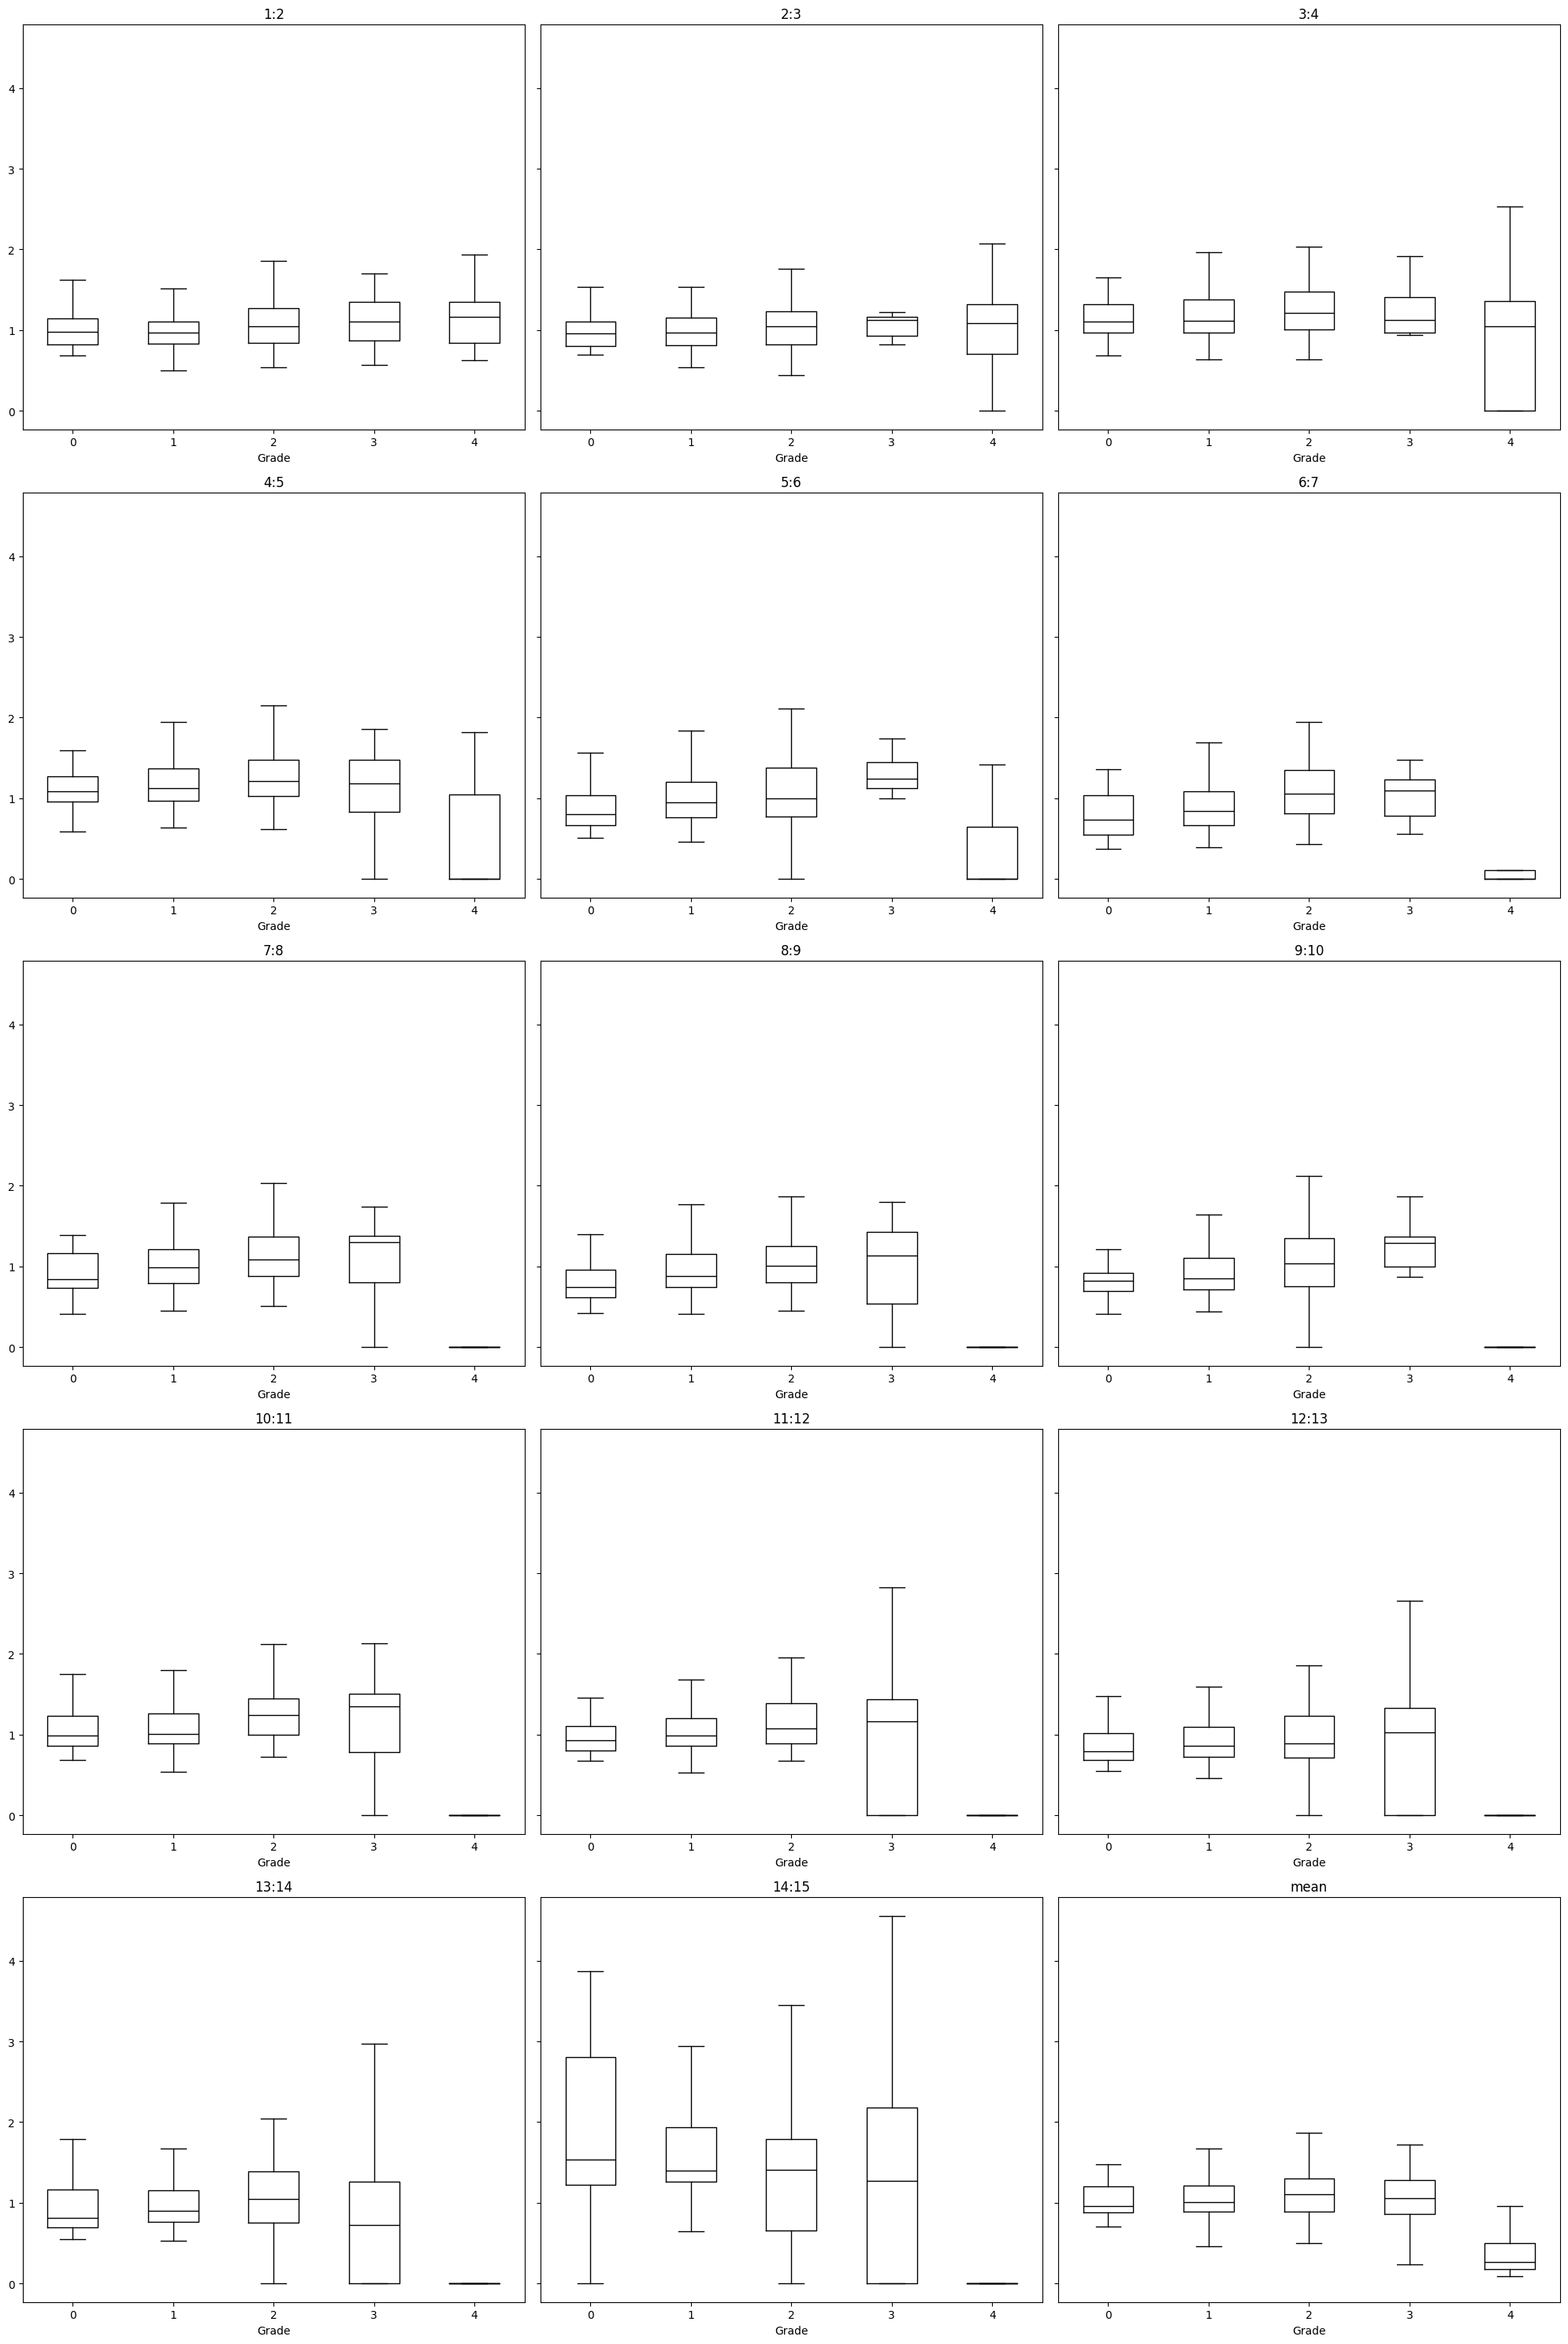

74040

In [89]:
boxplotter(distances_df, filename="Euclidean_distances")
#clear
del distances_df
gc.collect()

#### コサイ距離を用いて比較
コサイン距離が**低い**ほど，<span style="color: tomato; ">文章が似ている</span>（差が小さい）と言える．  
コサイン類似度が**高い**ほど，<span style="color: tomato; ">文章が似ている</span>（差が小さい）と言える．


In [90]:
def cosine_similarity(vec1, vec2):
    # ゼロベクトルのチェック
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0

    # SciPyのコサイン距離を使用してコサイン類似度を計算
    return 1 - distance.cosine(vec1, vec2)


cosdist_df = pd.DataFrame()
with util.timer(f"Calculate cosine Distance:"):
    for j in range(len(data_X[i])):
        for i in range(1, 15):
            name = f"{i}:{i+1}"
            vec1 = data_X[i].iloc[j].values
            vec2 = data_X[i + 1].iloc[j].values
            cosdist_df.loc[j, name] = 1-cosine_similarity(vec1, vec2)
        # 全ての列の平均値を計算
        cosdist_df.loc[j, "15:16"] = cosdist_df.loc[j].mean()
cosdist_df["Category"] = data_Y[1]["category_id"]


[Calculate cosine Distance:] start
[Calculate cosine Distance:] done in 2.31 s


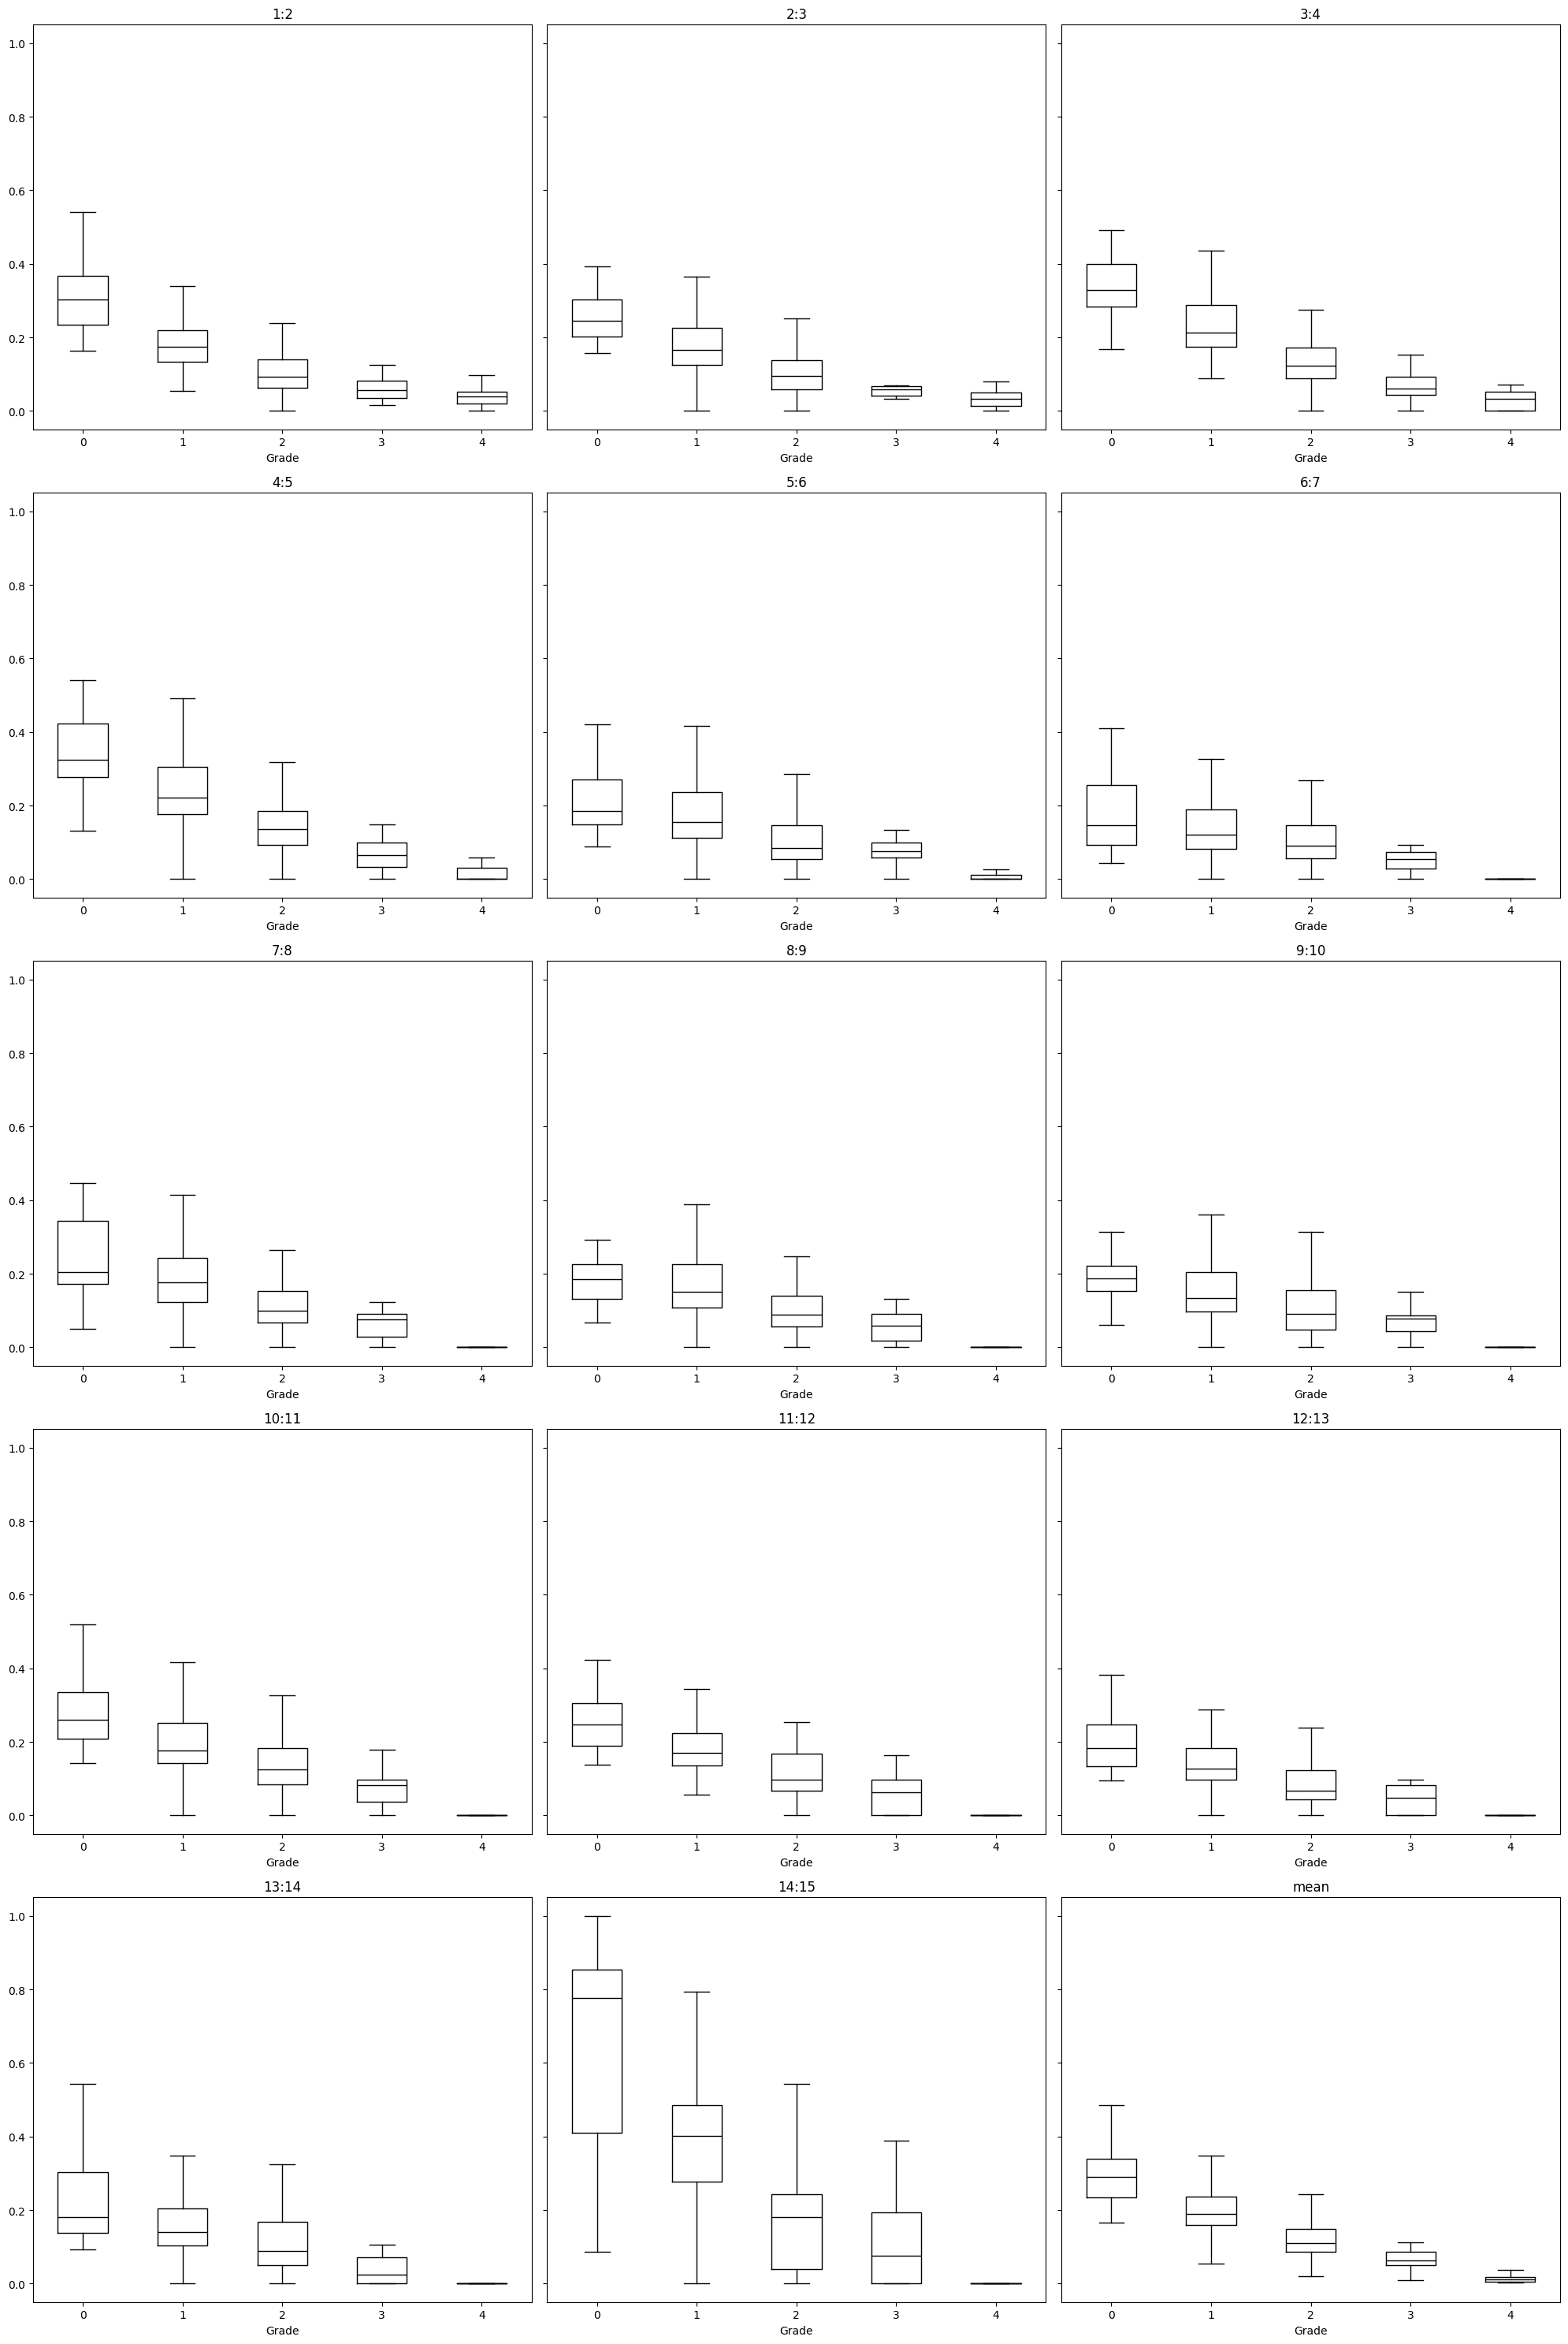

74967

In [91]:
boxplotter(cosdist_df, filename="Cosine_distances")
#clear
del cosdist_df
gc.collect()

In [92]:
# for i in range(1,16):
#     name = f"{i}:{i+1}"
#     cosdist_df.boxplot(column=name, by="Category", grid=False, showfliers=False, color="black")

# plt.suptitle("")
# plt.xlabel("label")
# plt.show()

In [93]:
manhattan_df = pd.DataFrame()
with util.timer(f"Calculate cityblock Distance:"):
    for j in range(len(data_X[i])):
        for i in range(1, 15):
            name = f"{i}:{i+1}"
            vec1 = data_X[i].iloc[j].values
            vec2 = data_X[i + 1].iloc[j].values
            # マンハッタン距離
            manhattan_df.loc[j, name] = distance.cityblock(vec1, vec2)
        # 全ての列の平均値を計算
        manhattan_df.loc[j, "15:16"] = manhattan_df.loc[j].mean()
manhattan_df["Category"] = data_Y[1]["category_id"]
manhattan_df.head()

[Calculate cityblock Distance:] start
[Calculate cityblock Distance:] done in 2.30 s


1:2        2:3        3:4        4:5        5:6        6:7  \
0  14.059848  10.967787  14.918737  13.393862  10.831274   9.145495   
1   9.704936   8.459094  17.150346  18.956447  12.043895  12.710584   
2  14.837971  12.852086  18.509598  19.268291  12.245502  15.320487   
3  11.976210   9.837041  11.401275  11.103114  11.896963   9.664414   
4   8.175194   8.203220  11.902407  12.355519   8.852500   6.872098   

         7:8        8:9       9:10      10:11      11:12      12:13  \
0  14.137173   0.000000   0.000000   0.000000   0.000000   0.000000   
1  21.302390  20.170624  18.284211  14.777496  13.195095  13.178650   
2  18.800962  11.355303  17.976483  15.553998  10.373305  10.205721   
3   9.487964   9.202395  10.156328  10.402268   8.993683   7.779524   
4   7.888784  10.478715   9.086202  10.081357  10.095517   6.254841   

       13:14      14:15      15:16  Category  
0   0.000000   0.000000   6.246727         4  
1  14.530942  32.918903  16.241687         1  
2  10.659665  43.825587  16.556068         2  
3   7.110912  21.422016  10.745293         1  
4   9.447957  10.353783   9.289150         1

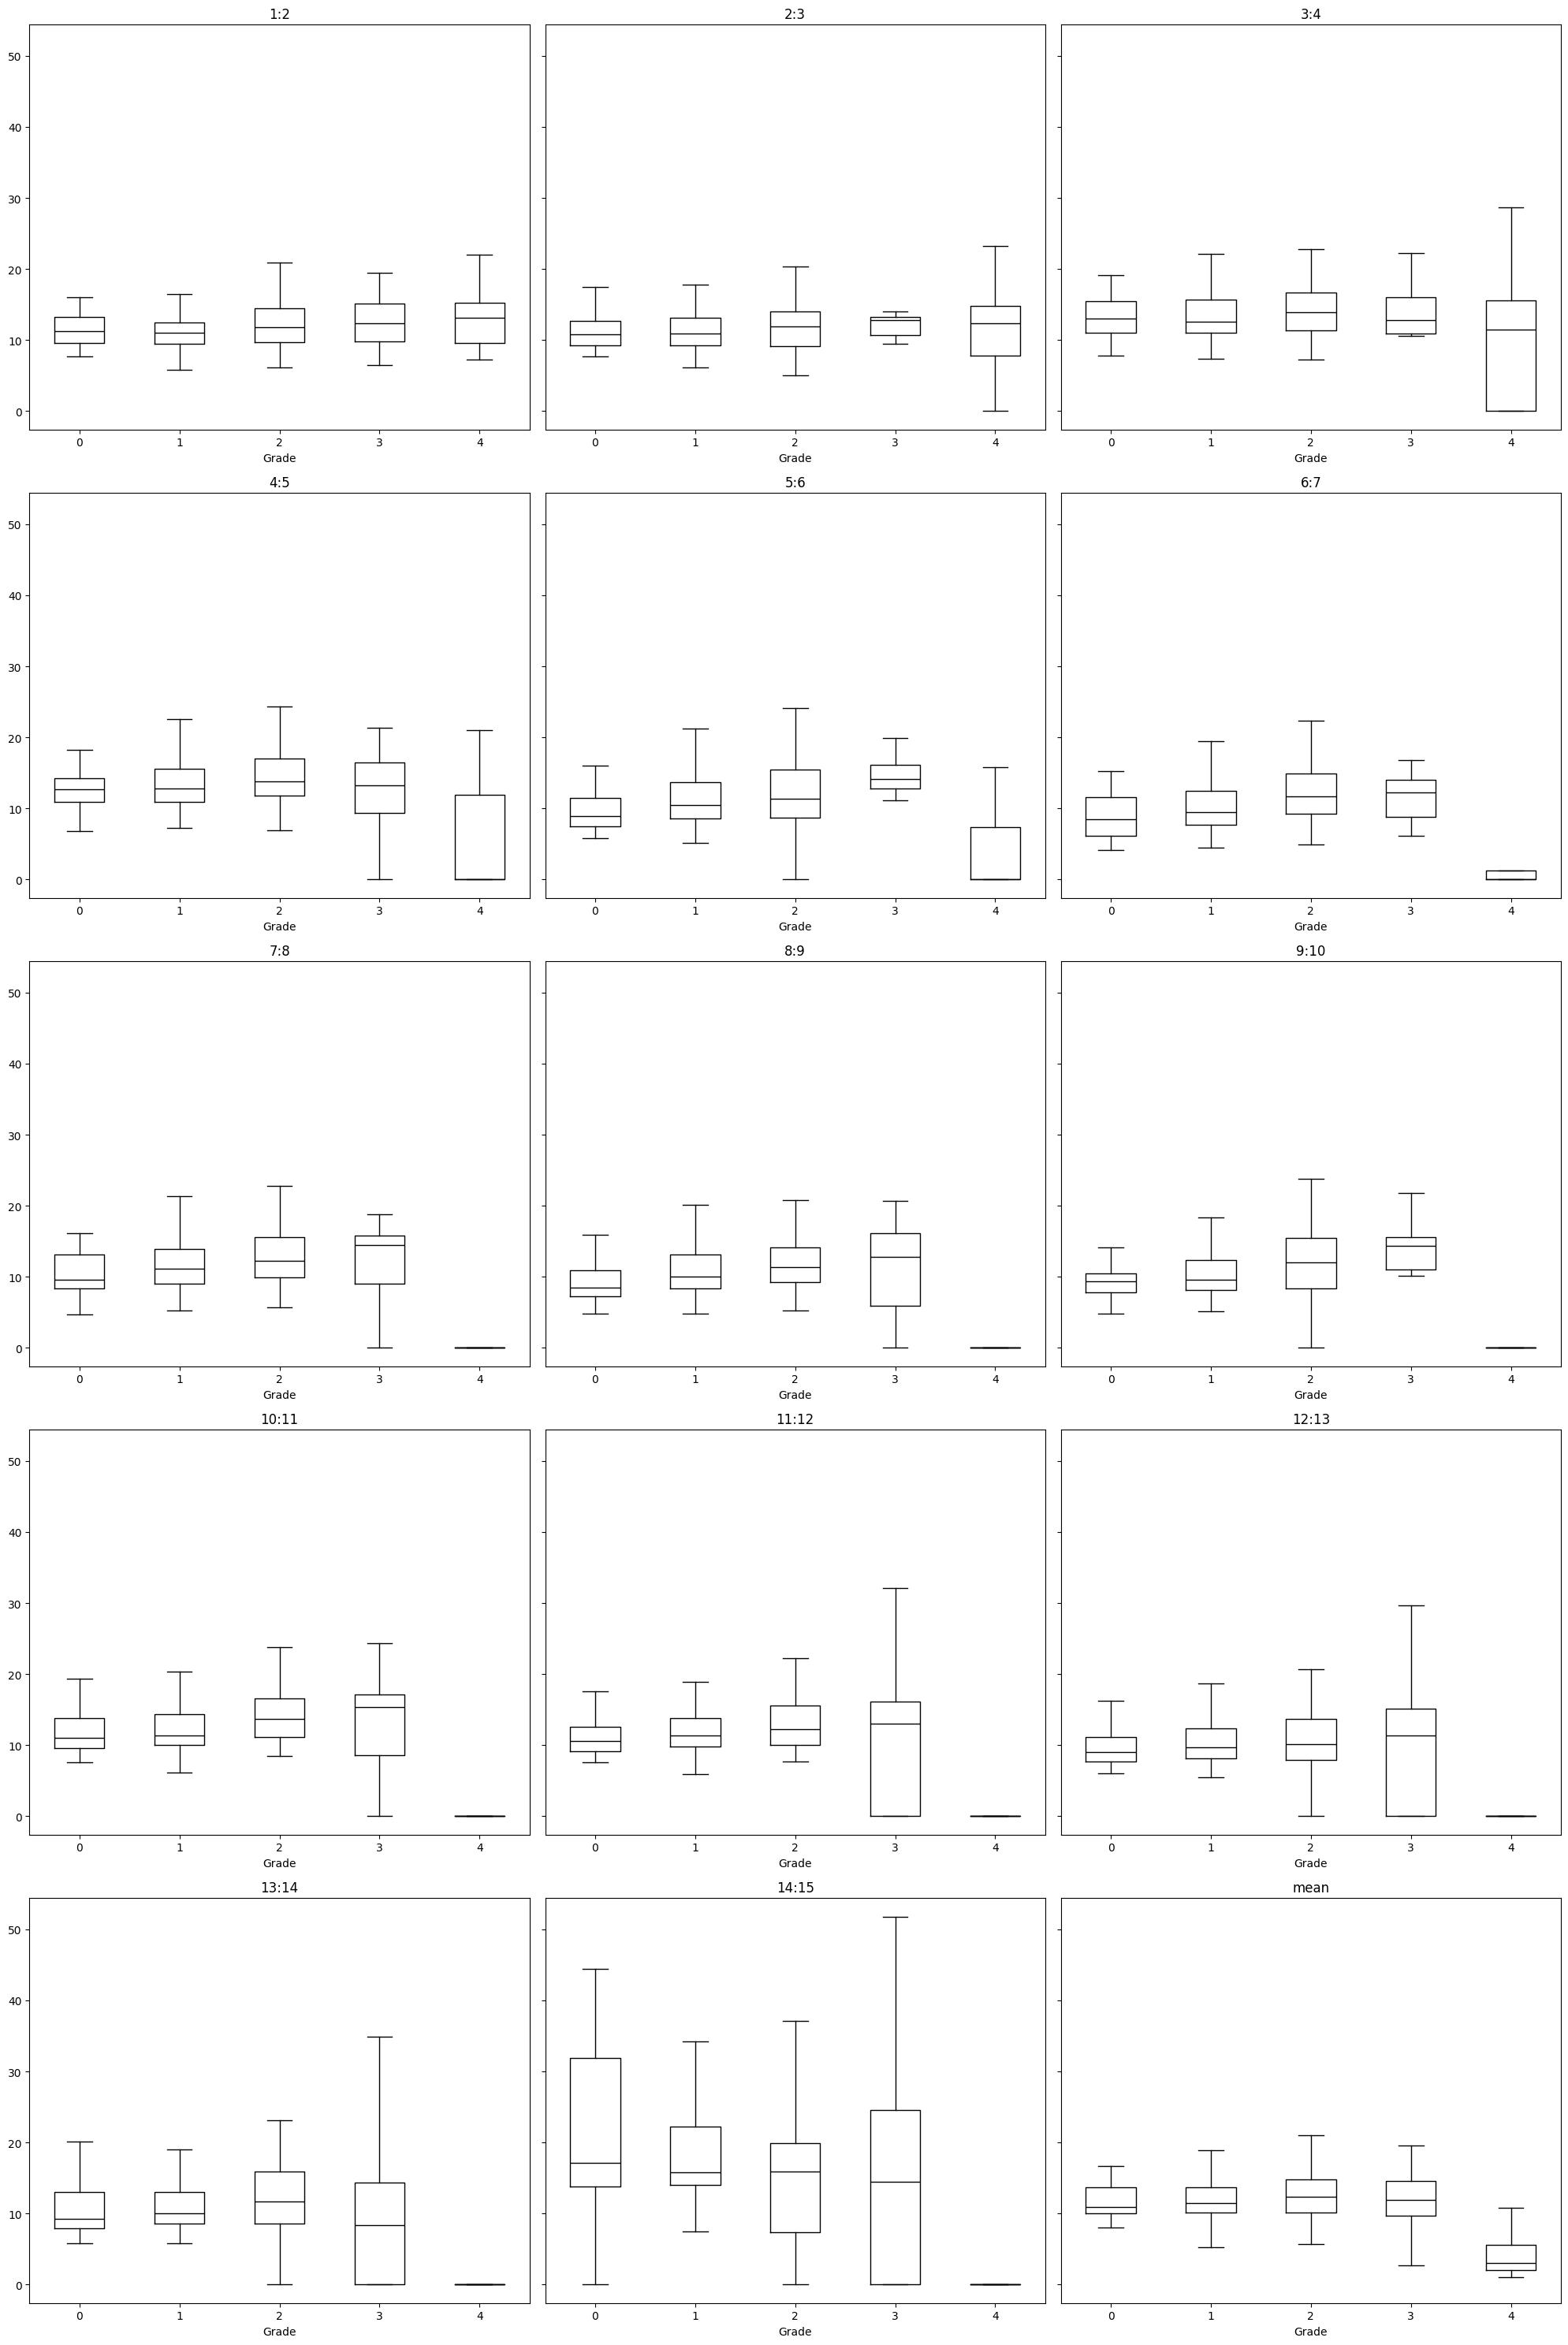

75355

In [94]:
boxplotter(manhattan_df, filename="Manhattan_distances")
#開放
del manhattan_df
gc.collect()

In [95]:
chebyshev_df = pd.DataFrame()
with util.timer(f"Calculate chebyshev Distance:"):
    for j in range(len(data_X[i])):
        for i in range(1, 15):
            name = f"{i}:{i+1}"
            vec1 = data_X[i].iloc[j].values
            vec2 = data_X[i + 1].iloc[j].values
            # チェビシェフ距離
            chebyshev_df.loc[j, name] = distance.chebyshev(vec1, vec2)
        # 全ての列の平均値を計算
        chebyshev_df.loc[j, "15:16"] = chebyshev_df.loc[j].mean()
chebyshev_df["Category"] = data_Y[1]["category_id"]
chebyshev_df.head()

[Calculate chebyshev Distance:] start
[Calculate chebyshev Distance:] done in 2.32 s


1:2       2:3       3:4       4:5       5:6       6:7       7:8  \
0  0.238598  0.212235  0.255261  0.269643  0.181395  0.170665  0.261697   
1  0.172437  0.138255  0.323519  0.356958  0.243421  0.237467  0.389876   
2  0.245888  0.204731  0.321933  0.367551  0.204686  0.259388  0.316574   
3  0.200957  0.155775  0.216896  0.196926  0.234598  0.190631  0.199940   
4  0.153747  0.166580  0.200050  0.207846  0.166655  0.136011  0.133186   

        8:9      9:10     10:11     11:12     12:13     13:14     14:15  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.318313  0.287362  0.291592  0.309743  0.303324  0.289235  0.777911   
2  0.222358  0.403595  0.276858  0.190160  0.196912  0.226458  0.751531   
3  0.140542  0.173567  0.194173  0.156290  0.157254  0.125700  0.398245   
4  0.162191  0.148058  0.146170  0.207837  0.109973  0.177212  0.164878   

      15:16  Category  
0  0.113535         4  
1  0.317101         1  
2  0.299187         2  
3  0.195821         1  
4  0.162885         1

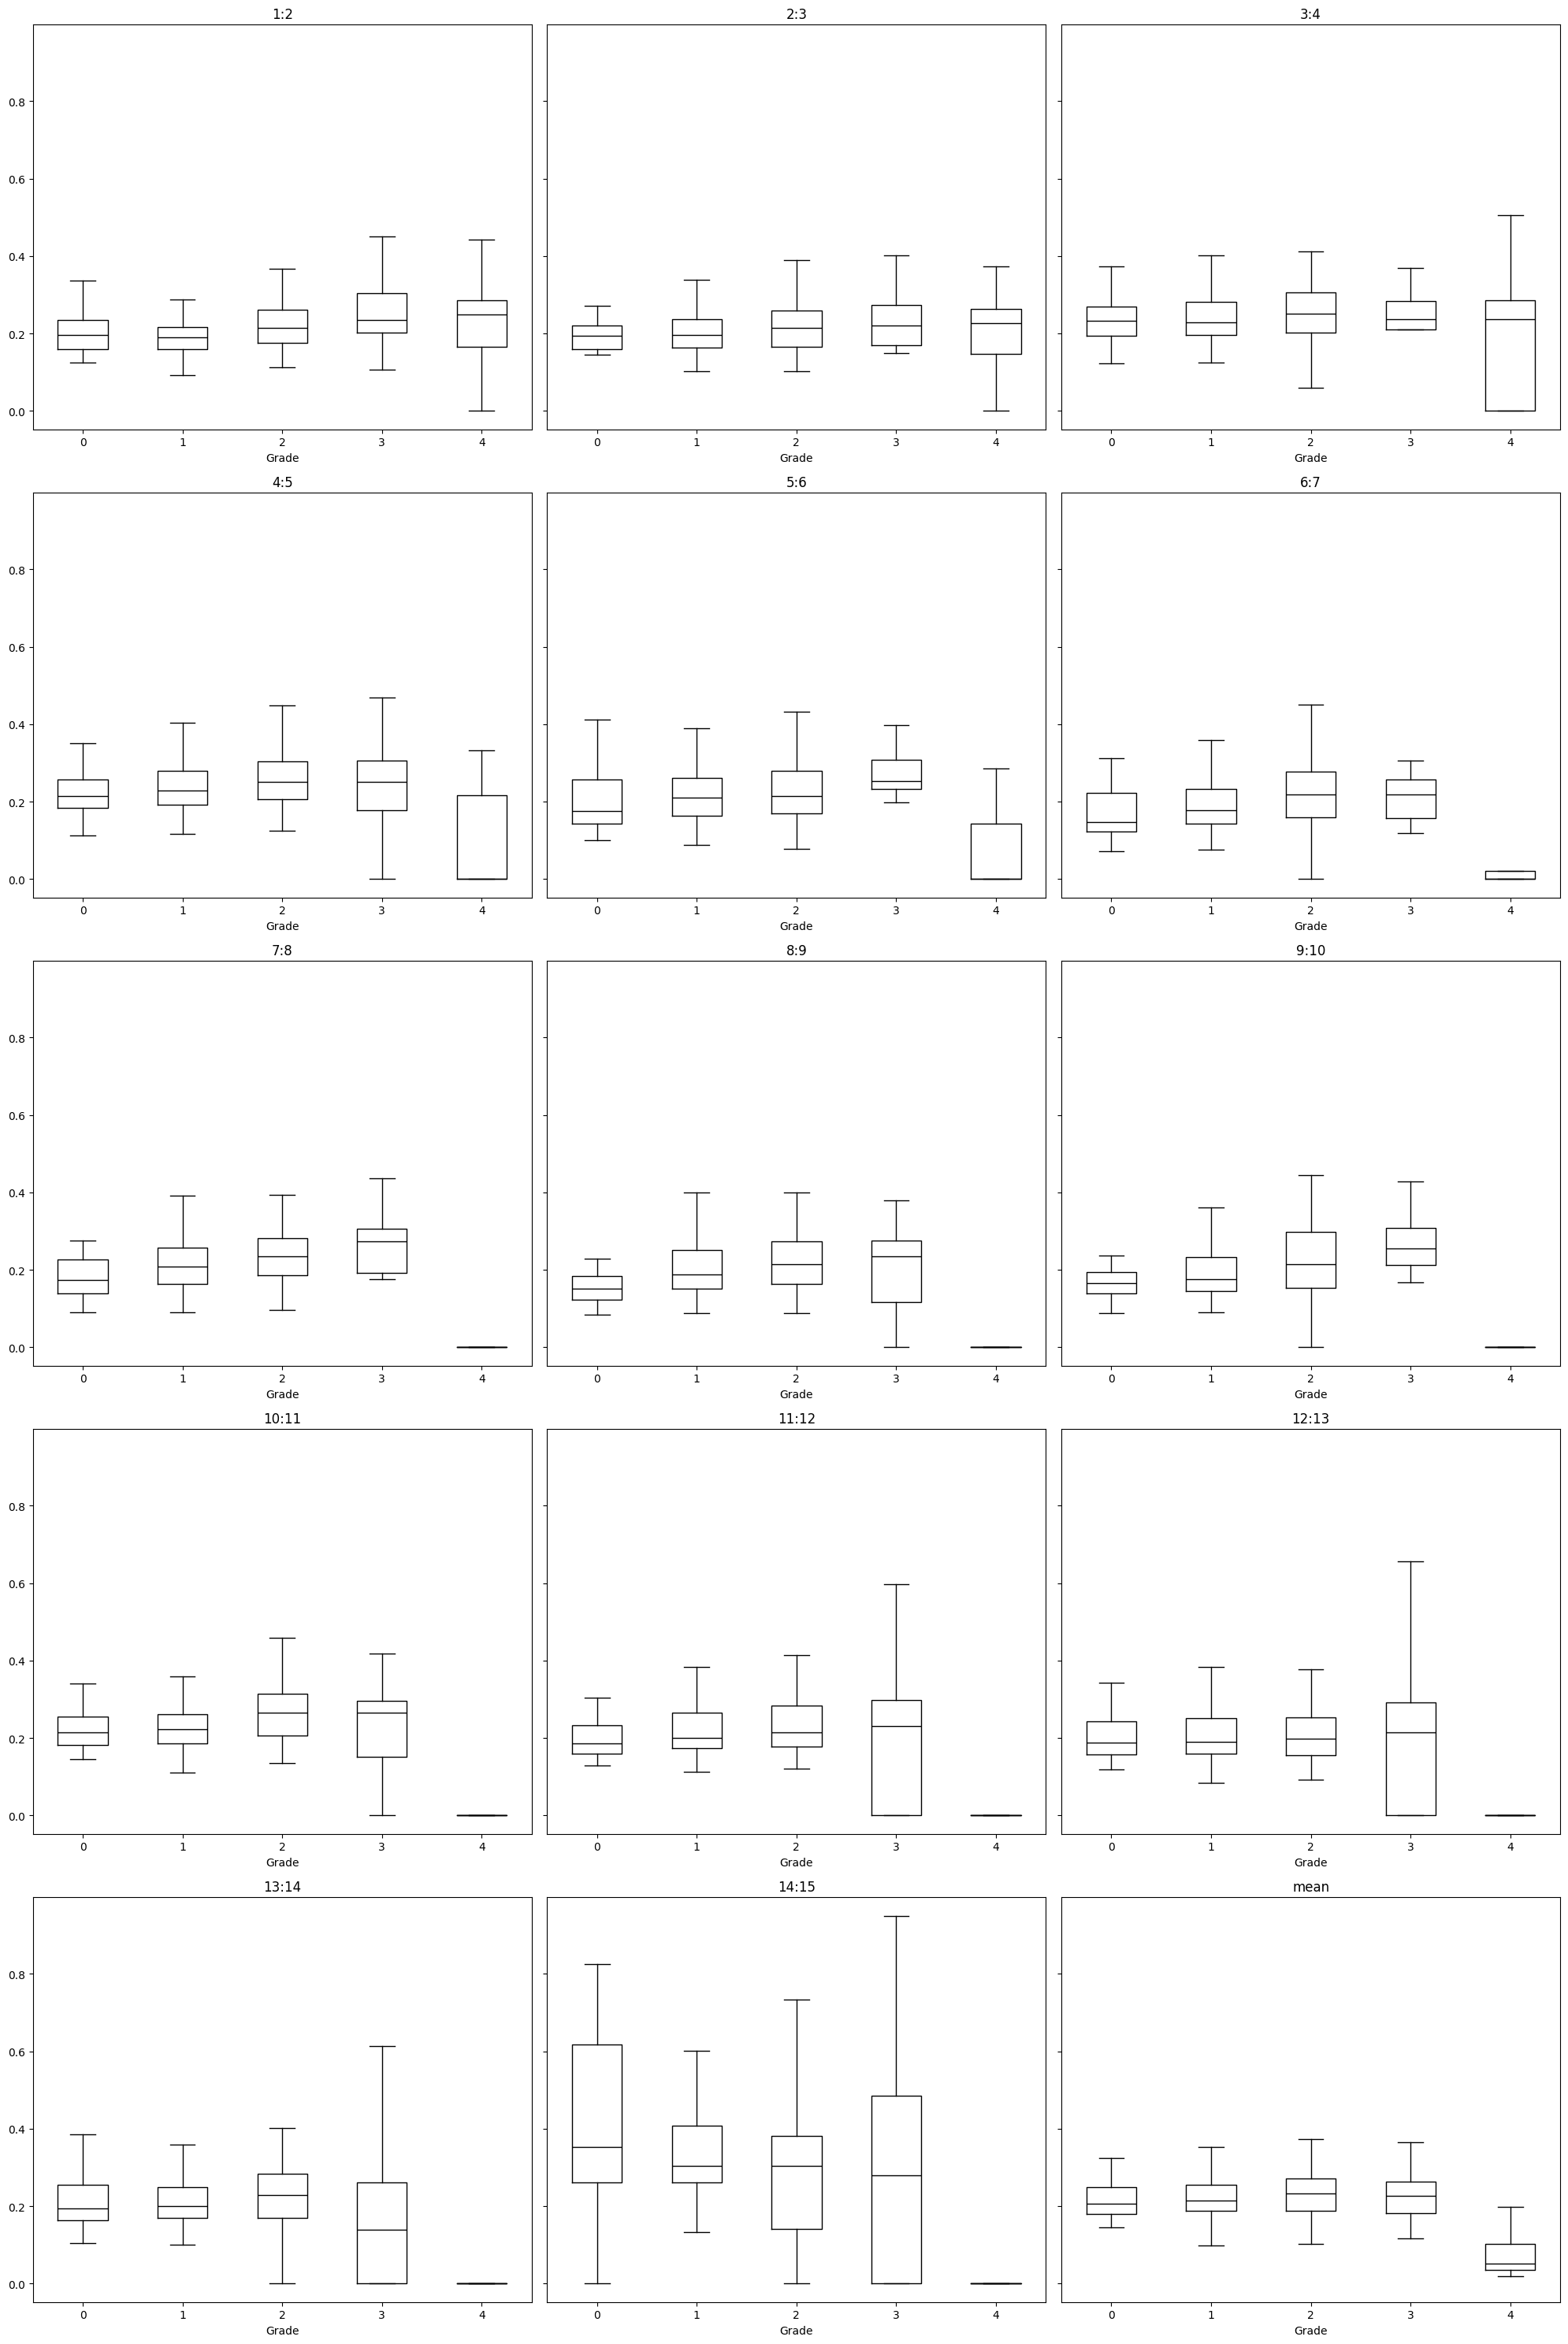

73738

In [96]:
boxplotter(chebyshev_df, filename="Chebyshev_distances")
#開放
del chebyshev_df
gc.collect()

In [97]:
minkowski_df = pd.DataFrame()
with util.timer(f"Calculate chebyshev Distance:"):
    for j in range(len(data_X[i])):
        for i in range(1, 15):
            name = f"{i}:{i+1}"
            vec1 = data_X[i].iloc[j].values
            vec2 = data_X[i + 1].iloc[j].values
            # ミンコフスキー距離
            minkowski_df.loc[j, name] = distance.minkowski(vec1, vec2, 3)
        # 全ての列の平均値を計算
        minkowski_df.loc[j, "15:16"] = minkowski_df.loc[j].mean()
minkowski_df["Category"] = data_Y[1]["category_id"]
minkowski_df.head()

[Calculate chebyshev Distance:] start
[Calculate chebyshev Distance:] done in 2.52 s


1:2       2:3       3:4       4:5       5:6       6:7       7:8  \
0  0.572916  0.470880  0.622763  0.565541  0.472059  0.392894  0.635914   
1  0.415648  0.350976  0.703681  0.790318  0.526868  0.557243  0.899906   
2  0.601197  0.550851  0.768686  0.802520  0.514858  0.650700  0.802243   
3  0.500622  0.400428  0.495048  0.471613  0.497115  0.406655  0.403044   
4  0.361595  0.357902  0.482294  0.519023  0.371696  0.299978  0.328363   

        8:9      9:10     10:11     11:12     12:13     13:14     14:15  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.836273  0.763791  0.649406  0.587166  0.594418  0.621410  1.449295   
2  0.487654  0.794954  0.645234  0.448133  0.453709  0.467180  1.844767   
3  0.379816  0.441879  0.440610  0.385590  0.344670  0.299243  0.892281   
4  0.437377  0.389679  0.402504  0.424984  0.270883  0.388534  0.428598   

      15:16  Category  
0  0.266641         4  
1  0.696171         1  
2  0.702335         2  
3  0.454187         1  
4  0.390244         1

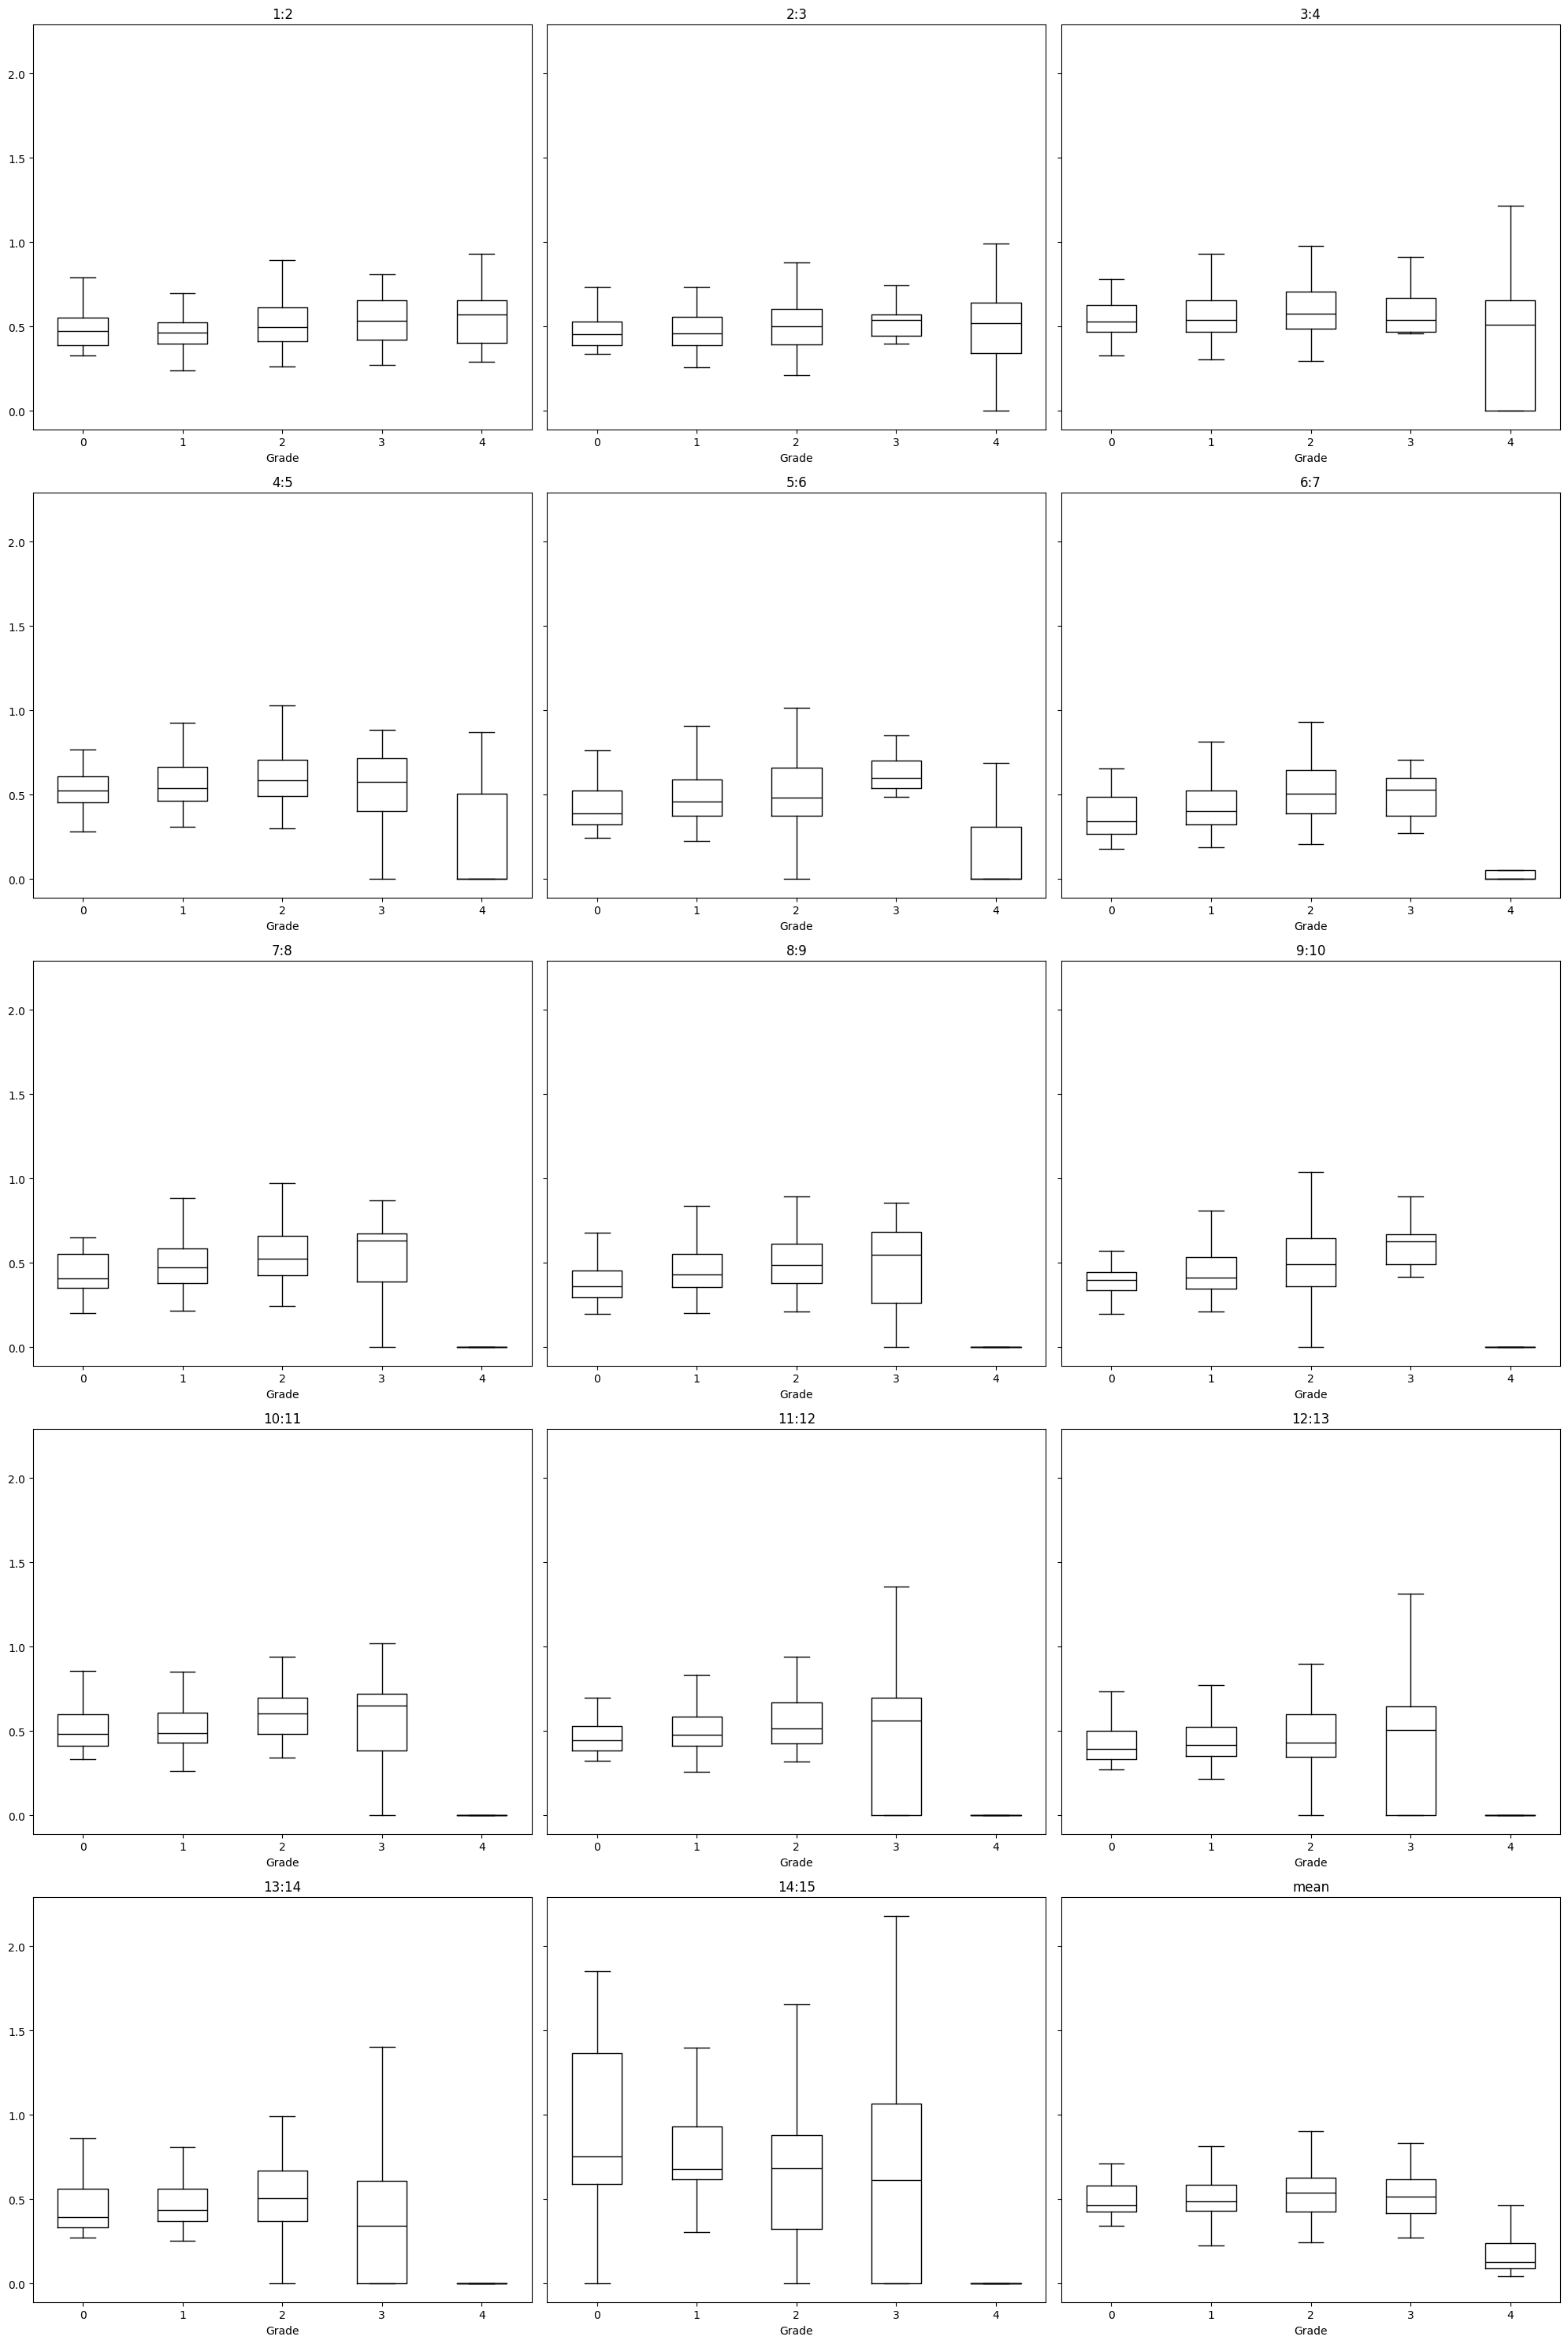

73718

In [98]:
boxplotter(minkowski_df, filename="Minkowski_distances")
#minkowski_dfの開放
del minkowski_df
gc.collect()

### heatmapで可視化
#### ユークリッド距離

In [99]:
data_X[1]["Category"].unique()

array([4, 1, 2, 3, 0])

In [100]:
data_X["Category"] = data_Y[1]["category_id"]
# Categoryごとにデータを分割
data_grade = {i: {} for i in range(5)}
for i in range(5):
    for j in range(1,16):
        data_grade[i][j] = data_X[j][data_X["Category"] == i].copy()
        data_grade[i][j].drop("Category", axis=1, inplace=True, errors="ignore")

# 各ベクトルの平均値を計算
mean_vec = {}
for j in range(5):
    mean_vec[j] = [data_grade[j][i].mean(axis=0).values for i in range(1, 16)]

#data_gradeの開放
del data_grade
gc.collect()

804

In [101]:
heat_distances_df = pd.DataFrame(
    index=[f"{i}" for i in range(1, 16)], columns=[f"{i}" for i in range(1, 16)]
)

[Calculate All Euclidean Distance for Category 0:] start


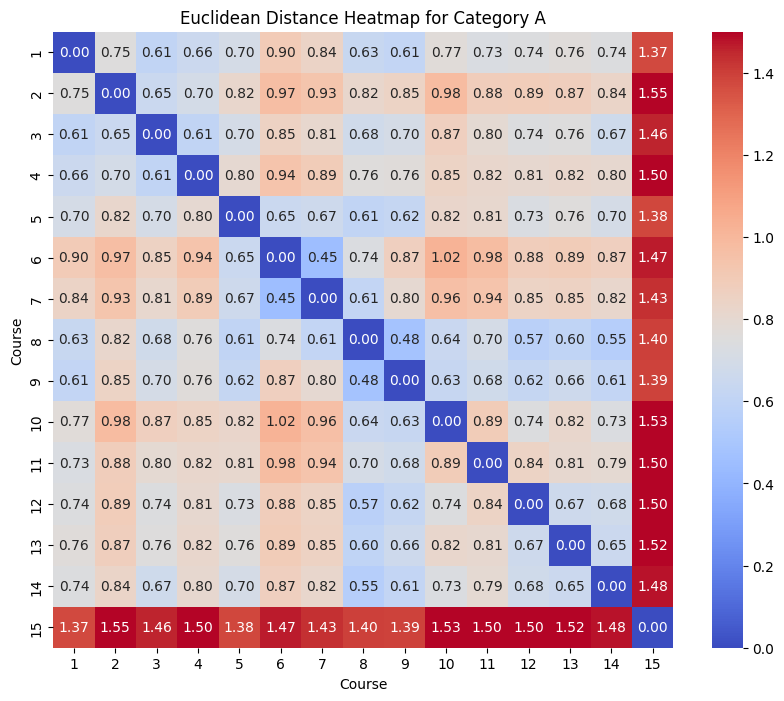

[Calculate All Euclidean Distance for Category 0:] done in 0.95 s
[Calculate All Euclidean Distance for Category 1:] start


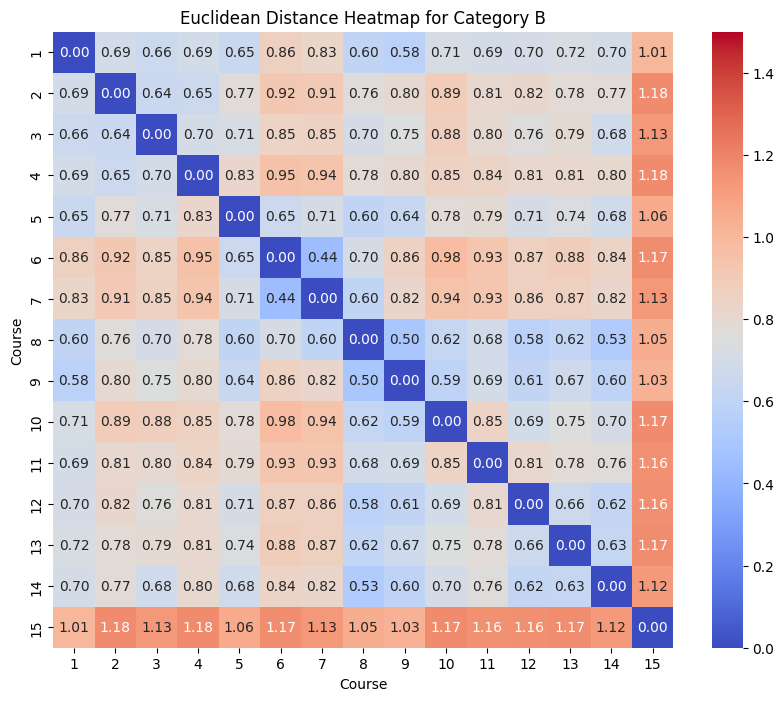

[Calculate All Euclidean Distance for Category 1:] done in 0.94 s
[Calculate All Euclidean Distance for Category 2:] start


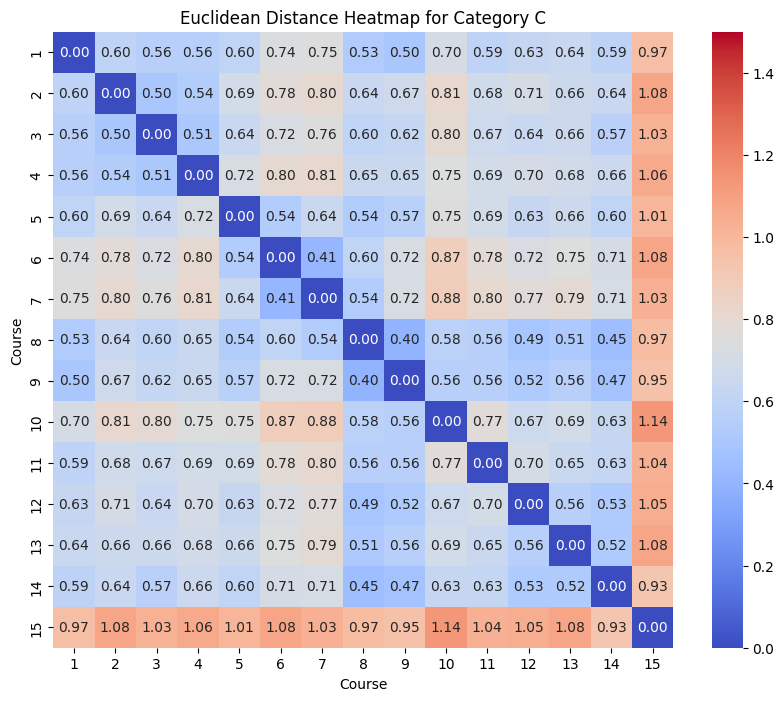

[Calculate All Euclidean Distance for Category 2:] done in 0.95 s
[Calculate All Euclidean Distance for Category 3:] start


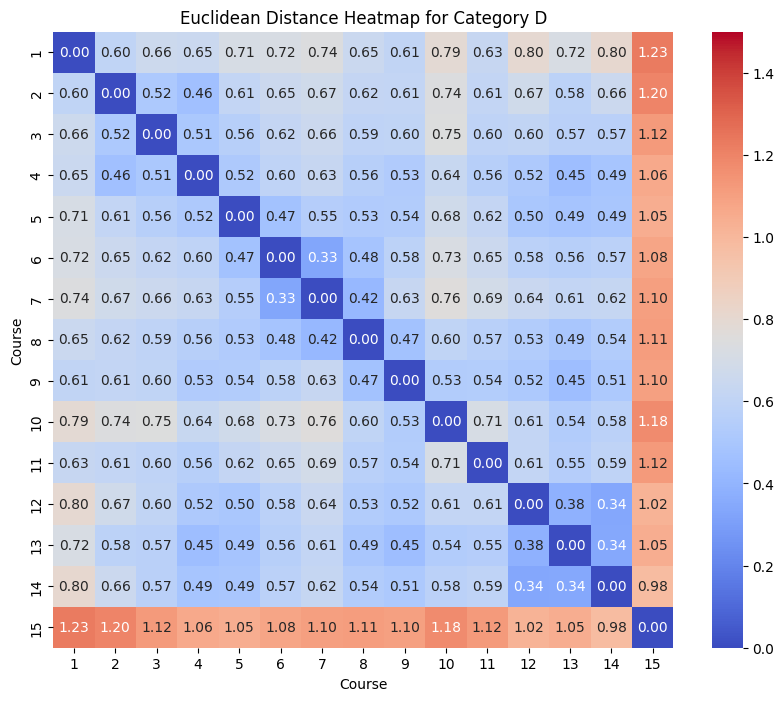

[Calculate All Euclidean Distance for Category 3:] done in 0.94 s
[Calculate All Euclidean Distance for Category 4:] start


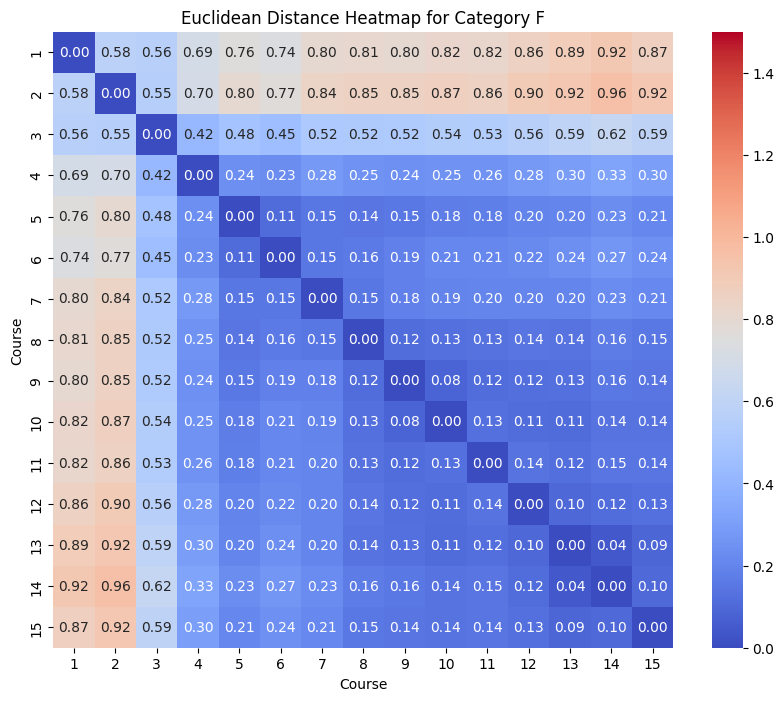

[Calculate All Euclidean Distance for Category 4:] done in 1.11 s


In [102]:
# 距離の計算とヒートマップの描画
for category in range(5):
    with util.timer(f"Calculate All Euclidean Distance for Category {category}:"):
        for i in range(1, 16):
            for j in range(1, 16):
                if i != j:
                    vec1 = mean_vec[category][i-1]
                    vec2 = mean_vec[category][j-1]
                    heat_distances_df.loc[f"{i}", f"{j}"] = np.linalg.norm(vec1 - vec2)
                else:
                    heat_distances_df.loc[f"{i}", f"{j}"] = 0.0

        # ヒートマップのプロット
        plt.figure(figsize=(10, 8))
        
        sns.heatmap(heat_distances_df.astype(float), annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1.5)
        plt.title(f'Euclidean Distance Heatmap for Category {index[category]}')
        plt.xlabel('Course')
        plt.ylabel('Course')
        plt.savefig(FIG_PATH / f"Euclidean_distance_heatmap_Grade{index[category]}.svg")
        plt.show()

#### コサイン距離

In [103]:
data_X["Category"] = data_Y[1]["category_id"]
# Categoryごとにデータを分割
data_grade = {i: {} for i in range(5)}
for i in range(5):
    for j in range(1, 16):
        data_grade[i][j] = data_X[j][data_X["Category"] == i].copy()
        data_grade[i][j].drop("Category", axis=1, inplace=True, errors="ignore")

# 各ベクトルの平均値を計算
mean_vec = {}
for j in range(5):
    mean_vec[j] = [data_grade[j][i].mean(axis=0).values for i in range(1, 16)]

# data_gradeの開放
del data_grade
gc.collect()

21252

In [108]:
mean_vec[4][0]

array([-7.64252543e-02,  5.26466183e-02, -6.75044768e-03,  6.16038777e-03,
       -9.90063399e-02,  5.88202029e-02, -1.90801620e-02,  1.10643685e-01,
        5.47447288e-03, -3.95854115e-02, -4.24679667e-02, -1.90385073e-01,
       -8.20107162e-02,  1.05436191e-01, -8.27387571e-02, -1.47504389e-01,
       -4.77108099e-02, -7.03715980e-02,  6.38024360e-02, -1.22850016e-02,
        9.96023118e-02,  1.42747954e-01, -7.09101334e-02,  4.81569692e-02,
        1.06947152e-02, -4.97099012e-02,  1.82191096e-02, -1.03898002e-02,
       -1.05471209e-01,  2.00150181e-02, -7.67156063e-03, -4.93519520e-03,
       -7.23707229e-02, -2.09069550e-02, -9.05804634e-02, -6.77631721e-02,
       -7.68203195e-03, -8.96806940e-02,  2.49902857e-03, -3.21911229e-03,
       -1.49310390e-02,  4.83828597e-03,  3.94250266e-02,  2.52798875e-03,
        1.43745661e-01, -2.32502371e-02,  5.82604334e-02,  8.08227435e-03,
       -4.39324006e-02, -1.15564261e-02, -7.92088807e-02,  5.03169000e-02,
        5.93648925e-02,  

In [109]:
heat_distances_df = pd.DataFrame(
    index=[f"{i}" for i in range(1, 16)], columns=[f"{i}" for i in range(1, 16)]
)

2024-07-26 05:36:38,556 : python.util : INFO : 9 : vec1: [-1.08832419e-01  5.28126918e-02  1.16140759e-02  5.71514305e-04
 -1.16935484e-01  7.91355595e-02 -4.80562858e-02  1.49245828e-01
  2.34591477e-02 -2.72184964e-02 -5.86790442e-02 -2.22007126e-01
 -8.72628987e-02  1.23015776e-01 -9.80730206e-02 -1.71097100e-01
 -6.25991002e-02 -7.37620518e-02  7.46779516e-02 -2.66994350e-02
  1.26689211e-01  1.99032992e-01 -9.25900713e-02  3.33911777e-02
  3.56074156e-06 -5.15996367e-02  1.62518006e-02  2.30468344e-02
 -1.34212643e-01  3.60071287e-02 -7.85186049e-03  9.13322810e-03
 -9.33839381e-02 -3.30912992e-02 -1.08959340e-01 -1.01100296e-01
 -3.53806093e-03 -9.56449211e-02 -2.23933831e-02  6.02357369e-03
 -2.26629004e-02  3.85638350e-03  4.32671569e-02  1.92942023e-02
  1.90030739e-01 -4.28754725e-02  4.95796800e-02  2.10988130e-02
 -4.16551381e-02 -2.01292876e-02 -7.06197247e-02  5.11671454e-02
  7.73085356e-02  5.62573746e-02  1.43814191e-01  5.77316992e-03
  4.81925532e-02  1.12083003e-01 

[Calculate All Euclidean Distance for Category 0:] start


2024-07-26 05:36:38,761 : python.util : INFO : 9 : vec1: [-9.26709846e-02  5.28957844e-02  9.66728851e-02 -8.95431787e-02
 -7.34007061e-02  1.27769411e-01 -6.27852753e-02  2.02283069e-01
  1.35250270e-01 -6.97631463e-02 -3.77326719e-02 -2.02383295e-01
 -9.25464332e-02  6.97312430e-02 -6.19713329e-02 -1.08938925e-01
 -6.95464239e-02 -5.16492464e-02  2.89461985e-02 -1.62718698e-01
  7.56123960e-02  1.57019272e-01 -1.00024804e-01  2.31759287e-02
  1.10148164e-02  2.52444055e-02 -1.74460802e-02 -8.58743414e-02
 -1.89760715e-01  1.64765909e-01 -3.47558483e-02 -8.60358477e-02
 -7.38009810e-02 -5.01827188e-02 -1.58416241e-01 -1.40438586e-01
 -2.44904701e-02 -6.30942881e-02 -2.57631503e-02  9.22467280e-03
  2.02689543e-02  3.50632109e-02  9.75881815e-02  6.16177917e-02
  1.80179685e-01 -7.46877939e-02  5.16361855e-02  8.15306418e-03
 -7.34558031e-02 -2.96249893e-02  4.31054011e-02  4.49815057e-02
  1.02836855e-01 -8.84108362e-04  8.49399790e-02 -8.42945352e-02
  7.14976490e-02  1.58053860e-02 

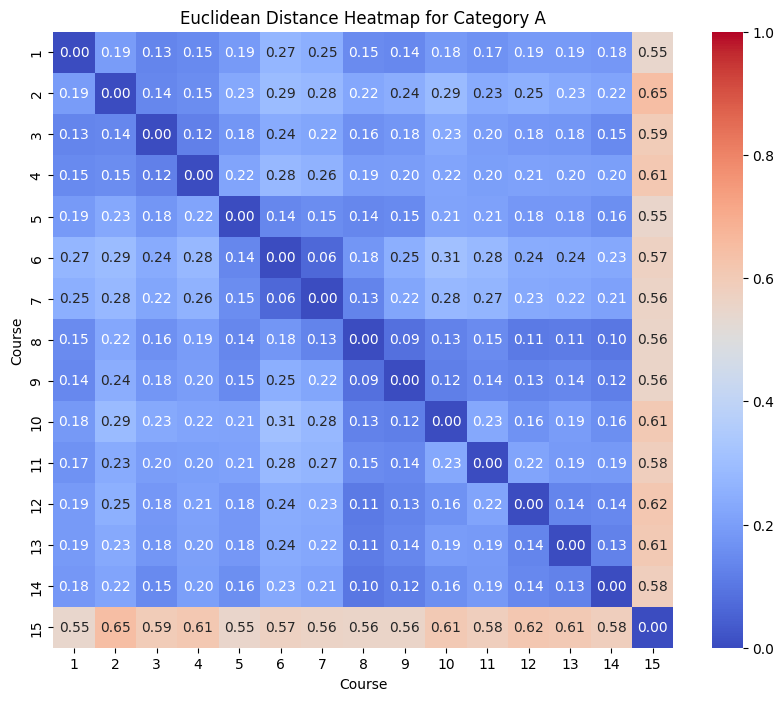

2024-07-26 05:36:40,659 : python.util : INFO : 9 : vec1: [-0.10400523  0.04811968 -0.00201176  0.00241469 -0.1074632   0.0784255
 -0.04458654  0.12786679  0.01545886 -0.02878813 -0.04963503 -0.2172561
 -0.09835681  0.13282639 -0.11040299 -0.16945781 -0.06718661 -0.07298353
  0.06535275 -0.03012171  0.12205728  0.17928666 -0.08656198  0.04711112
  0.00239483 -0.05571502  0.01916487  0.01680204 -0.1392835   0.03624136
 -0.00115217  0.01348519 -0.09355992 -0.03424862 -0.10668457 -0.10078818
  0.00196761 -0.1058104  -0.02054945  0.00059295 -0.02536023  0.00308864
  0.04099681  0.01227576  0.18314518 -0.02890287  0.04415109  0.01059925
 -0.04763028 -0.02489296 -0.08011437  0.04044524  0.06601409  0.05284834
  0.14335097  0.01375616  0.06277358  0.1097631  -0.02988568 -0.05509685
  0.04887121  0.00043141  0.07141294 -0.07605641 -0.09792901  0.09883088
  0.11041661  0.1823247  -0.13218935 -0.02002114  0.15374887 -0.00626679
  0.00822881 -0.03281423  0.02973883  0.06826789 -0.00618595 -0.06608

[Calculate All Euclidean Distance for Category 0:] done in 2.11 s
[Calculate All Euclidean Distance for Category 1:] start


2024-07-26 05:36:40,864 : python.util : INFO : 12 : heat_distance:0.21578187010392558
2024-07-26 05:36:40,867 : python.util : INFO : 9 : vec1: [-1.21580854e-01  6.80406019e-02  1.11101061e-01 -8.35909545e-02
 -8.81500766e-02  5.79344518e-02 -2.79179960e-02  1.44364953e-01
  4.88765948e-02 -5.09071797e-02 -4.17406932e-02 -1.36969090e-01
 -1.14376098e-01  1.10235512e-01 -9.33001041e-02 -1.47288308e-01
 -3.46436314e-02 -7.93561190e-02  5.05648851e-02 -1.42410964e-01
  4.38117459e-02  2.08641261e-01 -1.20905355e-01 -2.75219083e-02
 -6.50258269e-03  6.64991140e-03 -5.67797311e-02  8.24655127e-03
 -1.80686355e-01  6.14718422e-02 -1.92454122e-02 -1.37761131e-01
 -1.51821161e-02 -7.02976063e-02 -8.06363747e-02 -8.24226514e-02
 -6.81768823e-03 -1.39305055e-01  2.52005253e-02 -6.85103536e-02
  3.85395102e-02 -2.03099065e-02  8.12733993e-02  4.80721444e-02
  1.69309840e-01 -1.55131464e-04  1.29102049e-02 -1.20007042e-02
 -7.20914826e-02  2.50000088e-03 -3.01996935e-02 -1.45645682e-02
  1.56807840

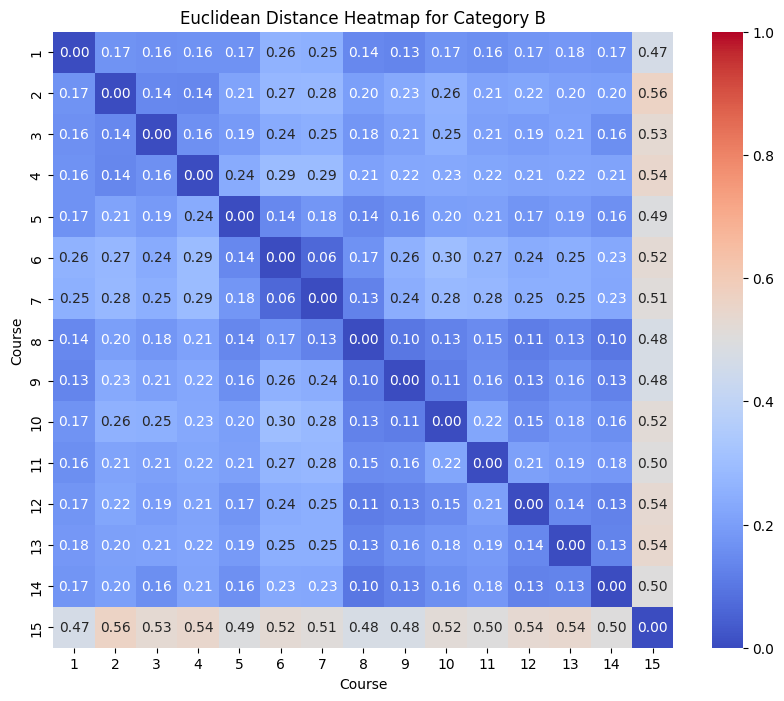

2024-07-26 05:36:42,436 : python.util : INFO : 9 : vec1: [-0.09746838  0.04969335 -0.0098029   0.00514477 -0.10825031  0.07417249
 -0.04011777  0.12756814  0.01383888 -0.02596971 -0.04974489 -0.21389093
 -0.09320607  0.12428618 -0.10245828 -0.1603423  -0.06879739 -0.05644308
  0.07633188 -0.01914064  0.1243132   0.17619048 -0.09495759  0.05168144
  0.00124749 -0.05902848  0.01580407  0.01045429 -0.13409631  0.02752083
 -0.00078796  0.0010138  -0.08156092 -0.03067543 -0.10263244 -0.09573029
  0.00945845 -0.09658676 -0.02279195  0.00713582 -0.02086312  0.00421157
  0.03444812  0.00820398  0.18464766 -0.02460534  0.04204446  0.01968331
 -0.03989185 -0.0129176  -0.09018085  0.04666518  0.05734944  0.03991938
  0.14281961  0.007465    0.065596    0.10003241 -0.02735009 -0.04232943
  0.03851582  0.00571648  0.07498658 -0.07626192 -0.09844109  0.10126283
  0.11228523  0.18771973 -0.13879262 -0.02519991  0.14610021  0.00224326
  0.01807339 -0.03242442  0.03448135  0.06915632 -0.00830872 -0.066

[Calculate All Euclidean Distance for Category 1:] done in 1.78 s
[Calculate All Euclidean Distance for Category 2:] start


2024-07-26 05:36:42,640 : python.util : INFO : 12 : heat_distance:0.20461567638583267
2024-07-26 05:36:42,642 : python.util : INFO : 9 : vec1: [-1.03185348e-01  5.15928641e-02  8.02966431e-02 -6.59856349e-02
 -7.18474537e-02  4.90775667e-02 -2.43544541e-02  1.30230740e-01
  4.68343124e-02 -4.87305596e-02 -3.76679488e-02 -1.32976070e-01
 -1.11505665e-01  1.11071050e-01 -8.69173929e-02 -1.38903424e-01
 -5.66032007e-02 -6.45220503e-02  5.21372147e-02 -1.01151116e-01
  7.10382164e-02  1.92166016e-01 -1.05743915e-01 -2.43760794e-02
 -9.59493034e-03 -1.60442460e-02 -5.60674146e-02 -1.74522470e-03
 -1.56627521e-01  4.00688499e-02 -2.05970462e-02 -9.10849348e-02
 -2.96179131e-02 -6.27498403e-02 -8.49301219e-02 -6.60683438e-02
 -5.72325476e-03 -1.04824945e-01  6.07940974e-03 -5.33466414e-02
  2.87610088e-02 -2.43367981e-02  6.14826083e-02  4.25795019e-02
  1.68448076e-01 -1.73427314e-02  1.80189982e-02 -1.83880534e-02
 -5.59642836e-02 -1.48369409e-02 -4.88167368e-02 -1.23269260e-02
  1.29482687

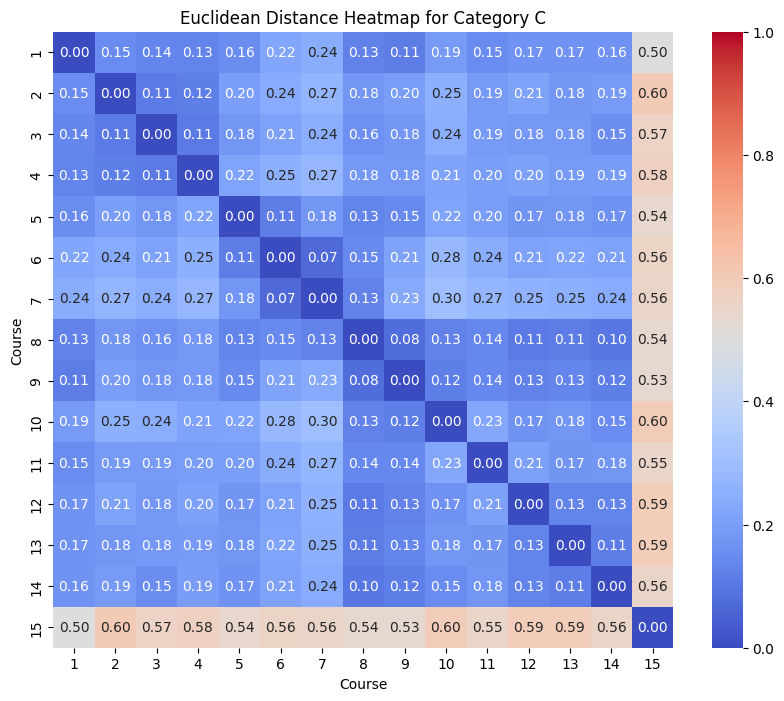

2024-07-26 05:36:44,408 : python.util : INFO : 9 : vec1: [-1.09142624e-01  5.71949072e-02 -6.83511654e-03  3.54135223e-02
 -1.27301857e-01  6.07383475e-02 -4.23845649e-02  1.36203200e-01
 -1.42816845e-02 -2.06388980e-02 -5.00517897e-02 -2.23784477e-01
 -7.92813748e-02  1.10678121e-01 -1.07440688e-01 -1.77046135e-01
 -7.93678761e-02 -5.37883453e-02  8.17282051e-02 -7.09459186e-03
  1.15270279e-01  1.85715169e-01 -9.52661335e-02  5.12462780e-02
 -5.47602540e-03 -6.82773888e-02  2.73912642e-02 -8.01560283e-03
 -1.63271740e-01  2.83563677e-02  3.42744170e-03  9.82367806e-03
 -8.90961513e-02 -3.49550210e-02 -9.98518318e-02 -7.89536089e-02
  1.35700824e-02 -8.24268833e-02 -2.36551668e-02  8.31259973e-03
 -1.33392839e-02  2.43347622e-02  4.47912440e-02  1.88842434e-02
  2.00936168e-01 -3.92118730e-02  7.88292140e-02  3.01644448e-02
 -4.97996397e-02 -3.94293107e-02 -1.04000606e-01  4.74790744e-02
  6.45182058e-02  4.86914329e-02  1.55542597e-01 -1.00225620e-02
  7.17088431e-02  1.18683085e-01 

[Calculate All Euclidean Distance for Category 2:] done in 1.97 s
[Calculate All Euclidean Distance for Category 3:] start


2024-07-26 05:36:44,612 : python.util : INFO : 12 : heat_distance:0.253381827990382
2024-07-26 05:36:44,615 : python.util : INFO : 9 : vec1: [-5.47156036e-02  3.88167426e-02  4.84784395e-02 -4.17593196e-02
 -4.14887480e-02  4.10055667e-02 -2.70051863e-02  1.01111077e-01
  2.72348635e-02 -3.79397683e-02 -2.95849442e-02 -8.50680694e-02
 -6.62008077e-02  5.48936725e-02 -8.35030973e-02 -9.56247896e-02
 -3.04434262e-02 -3.07228975e-02  3.94077450e-02 -8.03077668e-02
  3.34969237e-02  1.31770119e-01 -7.50038773e-02 -1.61988176e-02
  5.42187590e-05  2.27239355e-02 -1.62974112e-02 -3.24106589e-03
 -1.17803298e-01  4.78120968e-02  1.19121131e-02 -6.41092882e-02
 -2.55769901e-02 -3.03207133e-02 -5.73692843e-02 -5.46740666e-02
  1.10135297e-03 -8.89312476e-02  9.97421518e-03 -3.80998738e-02
  7.17323506e-03 -1.30755771e-02  5.63723147e-02  3.84738222e-02
  9.55429822e-02  1.52855297e-03  1.19721582e-02 -1.48607921e-02
 -4.80630733e-02  6.60905475e-03 -6.29084790e-03  1.24569274e-02
  1.07234016e-

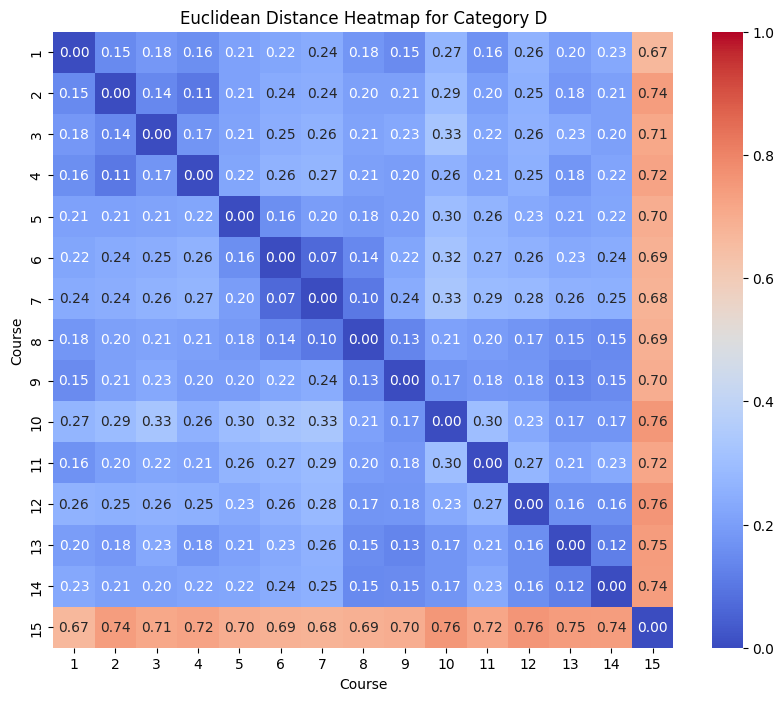

2024-07-26 05:36:46,320 : python.util : INFO : 9 : vec1: [-7.64252543e-02  5.26466183e-02 -6.75044768e-03  6.16038777e-03
 -9.90063399e-02  5.88202029e-02 -1.90801620e-02  1.10643685e-01
  5.47447288e-03 -3.95854115e-02 -4.24679667e-02 -1.90385073e-01
 -8.20107162e-02  1.05436191e-01 -8.27387571e-02 -1.47504389e-01
 -4.77108099e-02 -7.03715980e-02  6.38024360e-02 -1.22850016e-02
  9.96023118e-02  1.42747954e-01 -7.09101334e-02  4.81569692e-02
  1.06947152e-02 -4.97099012e-02  1.82191096e-02 -1.03898002e-02
 -1.05471209e-01  2.00150181e-02 -7.67156063e-03 -4.93519520e-03
 -7.23707229e-02 -2.09069550e-02 -9.05804634e-02 -6.77631721e-02
 -7.68203195e-03 -8.96806940e-02  2.49902857e-03 -3.21911229e-03
 -1.49310390e-02  4.83828597e-03  3.94250266e-02  2.52798875e-03
  1.43745661e-01 -2.32502371e-02  5.82604334e-02  8.08227435e-03
 -4.39324006e-02 -1.15564261e-02 -7.92088807e-02  5.03169000e-02
  5.93648925e-02  3.70076895e-02  1.24292418e-01  2.61971867e-03
  6.06998838e-02  8.54805633e-02 

[Calculate All Euclidean Distance for Category 3:] done in 1.91 s
[Calculate All Euclidean Distance for Category 4:] start


2024-07-26 05:36:46,523 : python.util : INFO : 12 : heat_distance:0.5950425400922662
2024-07-26 05:36:46,526 : python.util : INFO : 9 : vec1: [-0.00604609  0.00605063  0.00515544  0.00941738  0.00034706  0.02018723
 -0.00786453  0.01175197  0.01794579 -0.00505596 -0.00589921 -0.04064035
 -0.03128684  0.01675873 -0.00813124 -0.02270157 -0.00513035 -0.01552098
  0.01841566 -0.01829913  0.02550819  0.02640399 -0.00354169 -0.00564234
 -0.00255229 -0.0113057  -0.00782725 -0.02596202 -0.03173533  0.00022491
  0.01575575 -0.01004792 -0.01910705 -0.01512499 -0.02355185 -0.01086544
 -0.00800025 -0.03339929  0.0015977   0.00411999 -0.01103467  0.0078221
  0.00894767  0.00844804  0.03486523 -0.00702301  0.01962832 -0.00828454
  0.00020247  0.00562158 -0.02531275  0.00390634 -0.00474729  0.00366773
  0.02576923  0.01111249  0.01109217  0.00238285 -0.01059674 -0.00746689
  0.01671165  0.00727466 -0.00818162 -0.01892735 -0.00908345  0.00365572
  0.00956918  0.04860758 -0.02757079 -0.00424693  0.0032

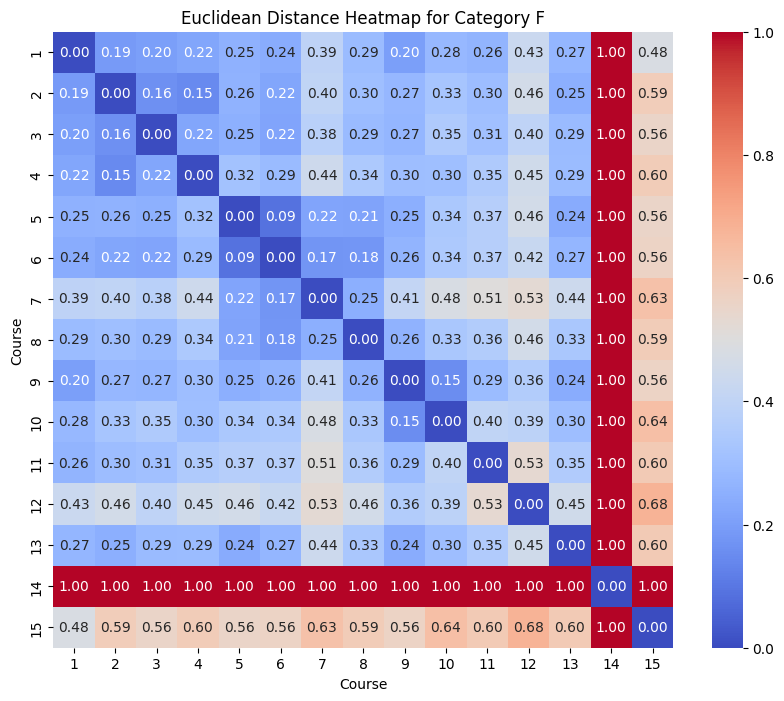

[Calculate All Euclidean Distance for Category 4:] done in 1.74 s


In [121]:
# 距離の計算とヒートマップの描画
for category in range(5):
    with util.timer(f"Calculate All Euclidean Distance for Category {category}:"):
        for i in range(1, 16):
            for j in range(1, 16):
                if i != j:
                    vec1 = mean_vec[category][i - 1]
                    vec2 = mean_vec[category][j - 1]
                    logger.info(f"vec1: {vec1} * vec2: {vec2}")
                    tmp = 1-cosine_similarity(vec1, vec2)
                    heat_distances_df.loc[f"{i}", f"{j}"] = tmp
                    logger.info(f"heat_distance:{tmp}")
                else:
                    heat_distances_df.loc[f"{i}", f"{j}"] = 0.0

        # ヒートマップのプロット
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            heat_distances_df.astype(float), annot=True, fmt=".2f", cmap="coolwarm", vmin=0, vmax=1
        )
        plt.title(f"Euclidean Distance Heatmap for Category {index[category]}")
        plt.xlabel("Course")
        plt.ylabel("Course")
        plt.savefig(FIG_PATH / f"Cosine_distance_heatmap_Grade{index[category]}.svg")
        plt.show()

In [112]:
heat_distances_df

1         2         3         4         5         6         7  \
1        0.0  0.189265   0.19996  0.220225  0.254329  0.239606  0.392485   
2   0.189265       0.0   0.16264  0.147539  0.261261  0.222087  0.401932   
3    0.19996   0.16264       0.0  0.218807  0.251282  0.215194  0.378509   
4   0.220225  0.147539  0.218807       0.0  0.315851  0.286736   0.44398   
5   0.254329  0.261261  0.251282  0.315851       0.0  0.086446    0.2152   
6   0.239606  0.222087  0.215194  0.286736  0.086446       0.0  0.173549   
7   0.392485  0.401932  0.378509   0.44398    0.2152  0.173549       0.0   
8   0.289426  0.301873  0.288681  0.342173  0.214338  0.177057  0.247583   
9    0.20121  0.274878  0.271926  0.300722  0.249821  0.264883  0.408039   
10  0.279023  0.326851  0.347881  0.302121  0.338894  0.342918  0.478153   
11  0.262901  0.295339  0.307981  0.348781  0.370569  0.368124  0.506081   
12  0.432666  0.458635  0.398324  0.452243  0.459836  0.424277  0.526194   
13  0.269555  0.248827  0.285861  0.290212  0.235337  0.271496  0.441213   
14       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
15  0.483867  0.590856  0.555212  0.595043  0.556215  0.562606   0.63487   

           8         9        10        11        12        13   14        15  
1   0.289426   0.20121  0.279023  0.262901  0.432666  0.269555  1.0  0.483867  
2   0.301873  0.274878  0.326851  0.295339  0.458635  0.248827  1.0  0.590856  
3   0.288681  0.271926  0.347881  0.307981  0.398324  0.285861  1.0  0.555212  
4   0.342173  0.300722  0.302121  0.348781  0.452243  0.290212  1.0  0.595043  
5   0.214338  0.249821  0.338894  0.370569  0.459836  0.235337  1.0  0.556215  
6   0.177057  0.264883  0.342918  0.368124  0.424277  0.271496  1.0  0.562606  
7   0.247583  0.408039  0.478153  0.506081  0.526194  0.441213  1.0   0.63487  
8        0.0  0.258231  0.334838  0.356527  0.458544  0.332824  1.0  0.593983  
9   0.258231       0.0  0.154435  0.291548  0.357437  0.241345  1.0   0.56331  
10  0.334838  0.154435       0.0  0.401148  0.388288  0.299232  1.0    0.6444  
11  0.356527  0.291548  0.401148       0.0  0.532855  0.354485  1.0  0.603518  
12  0.458544  0.357437  0.388288  0.532855       0.0  0.453082  1.0  0.682332  
13  0.332824  0.241345  0.299232  0.354485  0.453082       0.0  1.0   0.60268  
14       1.0       1.0       1.0       1.0       1.0       1.0  0.0       1.0  
15  0.593983   0.56331    0.6444  0.603518  0.682332   0.60268  1.0       0.0

In [117]:
temp_df = grade_df[4].copy()

In [119]:
temp_df.to_csv(DATA_PATH / "grade_f.csv", index=False)